<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Exercise_3_GNN_for_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Two moons with an invertible Neural Network

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

In [2]:
### modified coupling layer class
import torch
import torch.nn as nn
import torch.nn.functional as F

class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CouplingLayer, self).__init__()
        # Neural networks for the first half of the dimensions
        self.fc1 = nn.Linear(input_size // 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Translation coefficient
        self.fc3 = nn.Linear(hidden_size, input_size // 2)
        # Scaling coefficient
        self.fc4 = nn.Linear(hidden_size, input_size // 2)

    def forward(self, x):
        #print("___ inside the coupling layer's forward function____")
        #print("x is:"); print(x)
        #print("shape of x is:",x.shape)
        # Split the input into two halves
        x_a, x_b = x.chunk(2, dim=1)
        #print("shape x_a is:",x_a.shape)
        #print("shape x_b is:",x_b.shape)

        # Apply neural network to calculate coefficients
        h = F.relu(self.fc1(x_a))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling_before_exp = torch.tanh(self.fc4(h))### taking the tanh
        #print("_"*20)
        #print("scaling if I dont take tanh:"); print(scaling_before_exp)
        scaling = torch.exp(scaling_before_exp)


        # Apply the affine transformation
        y_b = x_b * scaling + translation

        # Concatenate the transformed halves
        y = torch.cat([x_a, y_b], dim=1)
        #print(" shape of y is (tensor after the coupling layer):");print(y.shape)
        return y, scaling_before_exp

    def backward(self, y):
        # Split the input into two halves
        y_a, y_b = y.chunk(2, dim=1)

        # Apply neural network to calculate coefficients (reverse)
        h = F.relu(self.fc1(y_a))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling_before_exp = self.fc4(h)
        scaling = torch.exp(torch.tanh(scaling_before_exp))

        # Reverse the operations to reconstruct the original input
        x_a = y_a
        x_b = (y_b - translation) / scaling

        # Concatenate the reconstructed halves
        x = torch.cat([x_a, x_b], dim=1)
        return x

In [3]:
class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks

        # List of coupling layers
        self.coupling_layers = nn.ModuleList([
            CouplingLayer(input_size, hidden_size) for _ in range(blocks)
        ])
        #print("self.input size is:",self.input_size)


        # List to store orthonormal matrices
        self.orthonormal_matrices = [self._get_orthonormal_matrix(input_size) for _ in range(blocks)]
        # print("set of orthogonal matrixes are")
        # print(self.orthonormal_matrices)
        # print("some test check: "); print(type(self.orthonormal_matrices[0]))
        # print("shape is:");print(self.orthonormal_matrices)

        # List to store scaling_before_exp for each block
        self.scaling_before_exp_list = []

    def _get_orthonormal_matrix(self, size):
        # Function to generate a random orthonormal matrix
        w = torch.randn(size, size)
        q, _ = torch.linalg.qr(w,'reduced')
        return q

    def forward_realnvp(self, x):
        #print("inside the forward_realnvp function")
        scaling_before_exp_list = []
        for i in range(self.blocks):
            #print("type of (self.orthonormal_matrices[0]):",type(self.orthonormal_matrices[0]))
            #print("x is:");print(x)
            #print("self.orthonormal_matrices[i]:");print(self.orthonormal_matrices[i])

            # Apply random orthonormal matrix
            x = torch.matmul(x, self.orthonormal_matrices[i])

            # Apply coupling layer
            x, scaling_before_exp = self.coupling_layers[i].forward(x)
            scaling_before_exp_list.append(scaling_before_exp)

        self.scaling_before_exp_list = scaling_before_exp_list
        return x

    def encode(self, x):
        # Encoding is the forward pass through the RealNVP model
        return self.forward_realnvp(x)

    def decode(self, z):
        # Reverse transformations for decoding
        for i in reversed(range(self.blocks)):

            # Apply coupling layer (reverse)
            z = self.coupling_layers[i].backward(z)

            # Apply random orthonormal matrix (reverse)
            z = torch.matmul(z, self.orthonormal_matrices[i].t())
        return z

    def sample(self, num_samples=1000):
        # Generate random samples from a standard normal distribution
        with torch.no_grad():
            z = torch.randn(num_samples, self.input_size)

        # Apply the reverse transformations (decoder) to generate synthetic samples
        synthetic_samples = self.decode(z)
        return synthetic_samples

In [4]:
### defining our loss function
def calculate_loss(transformed_x, scaling_before_exp_list, dataset_length):
    """
    Calculate the loss for the RealNVP model.

    Args:
    - transformed_x (tensor): Transformed data produced by the RealNVP model.
    - scaling_before_exp_list (list): List of scaling_before_exp values for each block.
    - dataset_length (int): The length of the dataset.

    Returns:
    - loss (tensor): The calculated loss value.
    """
    #print("******************inside the calculate loss function**************")
    # print("transformed x's shape is:", transformed_x.shape)
    # print("scaling_before_exp_list is:", scaling_before_exp_list)

    # Calculate the first term of the loss (negative log-likelihood term)
    first_term = 0.5*torch.sum(transformed_x**2)

    # Calculate the second term of the loss (sum over scaling_before_exp values)
    # second_term = 0.0
    # for scaling_before_exp in scaling_before_exp_list:
    #     second_term -= scaling_before_exp.sum()

    second_term= -torch.sum(torch.cat(scaling_before_exp_list))#torch.sum(torch.stack(model.scaling_before_exp_list), dim=0)

    # Calculate the total loss
    loss = (first_term + second_term) / dataset_length
    #print(f"first term is: {first_term.item()} and the second term is {second_term.item()}")

    return loss


In [5]:
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

def train_and_evaluate(model, train_loader, val_loader, num_epochs=10, lr=0.001, print_after=1):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model (RealNVP): The RealNVP model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses

    for epoch in range(num_epochs):
        total_train_loss = 0.0

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs= data

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model.encode(inputs)

            # Loss calculation
            train_loss = calculate_loss(encoded, model.scaling_before_exp_list, len(train_loader))

            # Backward pass (gradient computation)
            train_loss.backward()

            ### added recently: clip the gradients
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

            # Update weights
            optimizer.step()

            total_train_loss += train_loss.item()

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data

                    # Forward pass (encoding) for validation
                    val_encoded = model.encode(val_inputs)

                    # Loss calculation for validation
                    val_loss = calculate_loss(val_encoded, model.scaling_before_exp_list, len(val_loader))

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}")

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    return train_losses, val_losses

### Some helper functions for plotting

In [6]:
# function to plot training and validation losses
def plot_losses(epoch_train_losses, epoch_val_losses, want_log_scale=True):
    """
    Plot training and validation losses over epochs on a log scale.

    Args:
        epoch_train_losses (list): List of training losses for each epoch.
        epoch_val_losses (list): List of validation losses for each epoch.
    """
    epochs = range(1, len(epoch_train_losses) + 1)

    plt.plot(epochs, epoch_train_losses, label='Training Loss')
    plt.plot(epochs, epoch_val_losses, label='Validation Loss')

    if want_log_scale:
      plt.yscale('log')  # Set the y-axis to a logarithmic scale
      plt.title('Training and Validation reconstruction Losses (Log Scale)',fontsize=10)
    else:
      plt.title('Training and Validation reconstruction Losses',fontsize=10)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [7]:
def visualize_synthetic_data(original_data, synthetic_data):
    """
    Scatter plot to visualize the original and synthetic data in 2D.

    Args:
    - original_data (torch.Tensor): Original data (2D).
    - synthetic_data (torch.Tensor): Synthetic data (2D).

    Returns:
    - None: Displays the scatter plot.
    """
    # Ensure both original and synthetic data are converted to numpy arrays
    with torch.no_grad():
        # Convert PyTorch tensors to numpy arrays
        original_np = original_data.numpy()
        synthetic_np = synthetic_data.numpy()

        # Scatter plot of original and synthetic data
        plt.scatter(original_np[:, 0], original_np[:, 1], label='Original', alpha=0.5)
        plt.scatter(synthetic_np[:, 0], synthetic_np[:, 1], label='Synthetic', alpha=0.5)

        # Add labels and title
        plt.xlabel("dimension-1")
        plt.ylabel("dimension-2")
        plt.title('Original vs Synthetic Data')

        # Add legend
        plt.legend()

        # Display the plot
        #plt.show()


In [8]:
def plot_code_distribution(model, test_loader, num_samples=1000):
    """
    Plot the code distribution obtained by applying the trained RealNVP model to a test dataset.

    Args:
    - model (RealNVP): Trained RealNVP model.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - num_samples (int): Number of samples to visualize.

    Returns:
    None (displays the plot).
    """
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Concatenate multiple batches to obtain more samples
        test_samples = torch.cat([batch for batch in test_loader], dim=0)

        # Assuming your model has an `encode` method
        code_samples = model.encode(test_samples[:num_samples])

        # Convert PyTorch tensor to numpy array
        code_np = code_samples.numpy()

        # Scatter plot of code distribution
        plt.scatter(code_np[:, 0], code_np[:, 1], label='Code Distribution', alpha=0.5)
        plt.xlabel("Code Dimension 1")
        plt.ylabel("Code Dimension 2")
        plt.title('Code Distribution')
        plt.legend()
        #plt.show()

### loading the two moons dataset

In [9]:
dataset_sizes = [ 100, 200,300,400,500,600,700,800,900, 1000, 5000]

# Generate datasets of varying sizes
train_datasets = {}
val_datasets = {}
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'X': X, 'y': y}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_datasets[size] = {'X': torch.FloatTensor(X_train), 'y': y_train}
    val_datasets[size] = {'X': torch.FloatTensor(X_test), 'y': y_test}

# # Visualize the training datasets
# plt.figure(figsize=(12, 8))

# for i, size in enumerate(dataset_sizes, 1):
#     plt.subplot(2, 2, i)
#     plt.scatter(datasets[size]['X'][:, 0], datasets[size]['X'][:, 1], c=datasets[size]['y'])
#     plt.title(f'Dataset Size: {size}')

# plt.show()


shape of the data_considered
torch.Size([3500, 2])
Epoch 1/10, Training Loss: -0.069945588813756, Validation Loss: -0.2947036237158674
Epoch 2/10, Training Loss: -0.13655666284559465, Validation Loss: -0.3800994145109298
Epoch 3/10, Training Loss: -0.15644234075126323, Validation Loss: -0.4005805108141392
Epoch 4/10, Training Loss: -0.15004104049876332, Validation Loss: -0.3940854034525283
Epoch 5/10, Training Loss: -0.17315212689678777, Validation Loss: -0.42223459038328615
Epoch 6/10, Training Loss: -0.17323222608220848, Validation Loss: -0.34632147388889434
Epoch 7/10, Training Loss: -0.17355674239383503, Validation Loss: -0.4644995800992276
Epoch 8/10, Training Loss: -0.18419327680021524, Validation Loss: -0.3325619826767039
Epoch 9/10, Training Loss: -0.18445073308592494, Validation Loss: -0.45367521745093325
Epoch 10/10, Training Loss: -0.18611254140057348, Validation Loss: -0.40497843128569583
Training complete


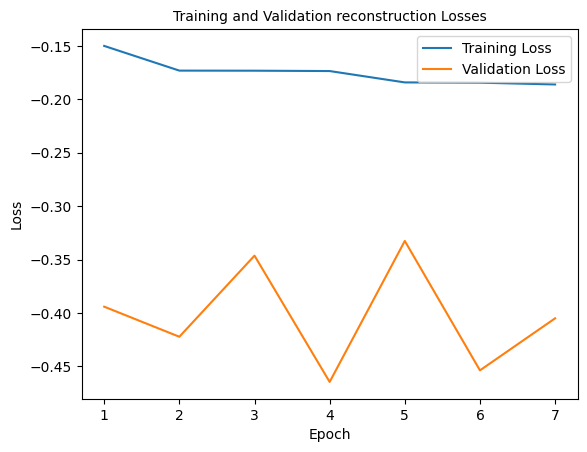

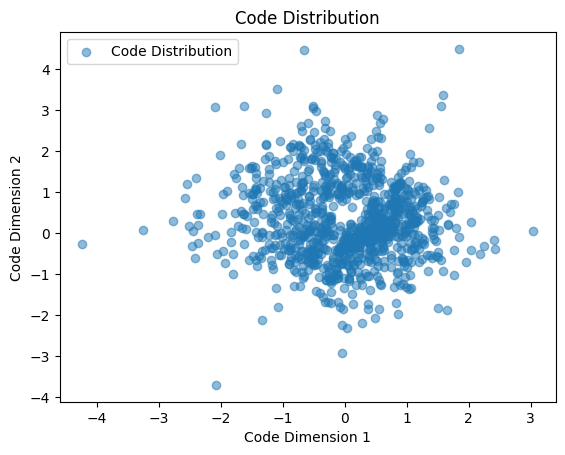

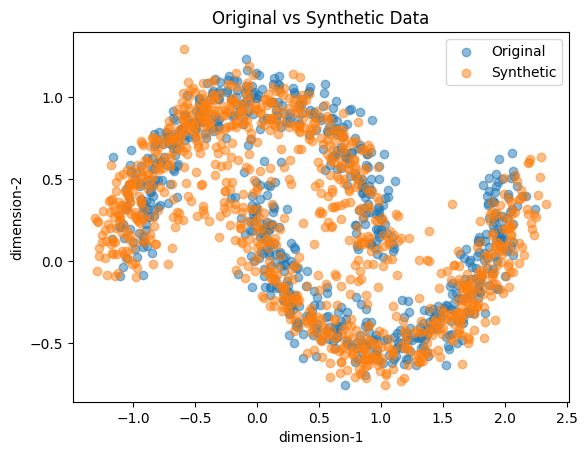

In [10]:
### Trial run: while creating and debugging the model. actual tasks for the assignment starts after this

### creating the dataloader for the make moons dataset
from torch.utils.data import DataLoader, TensorDataset

### Trial run
import numpy as np
input_size=2
hidden_size=200### do I really need this to be this large?
blocks=10 ####### larger number of blocks ensures that the code distribution is indeed gaussian
print_after=1

#### data for the two-moons model
dataset_size=5000
batch_size=32
data_considered=train_datasets[dataset_size]['X']
print("shape of the data_considered"); print(data_considered.shape)
train_loader = torch.utils.data.DataLoader(data_considered, batch_size=batch_size, shuffle=True)
val_loader= torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)
####

### instantiate the model
model= RealNVP(input_size=2, hidden_size= hidden_size, blocks=blocks)

## train the model
train_losses, val_losses= train_and_evaluate(model, train_loader, val_loader, num_epochs=10, lr=0.0001, print_after=1)
#train_inn(model, train_loader, num_epochs=500, lr=0.01, print_after=10)
#1. 0.00005 num_epochs=20,dataset_size=5000, batchsize=64: right now I have kept blocks=10: code distribution was more gaussian and generated data was comparitively better

# plotting the loss
plot_losses(train_losses[3:], val_losses[3:], want_log_scale=0)
plt.show()

# Example usage:
plot_code_distribution(model=model, test_loader=val_loader, num_samples=1000)
plt.show()

### plot the synthetic data and the original data
synthetic_data=model.sample(num_samples=1000)
visualize_synthetic_data(train_datasets[1000]['X'], synthetic_data)
plt.show()

### 1.1 Effect of number of coupling blocks in the network:

In [16]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

def compute_mmd(X, Y, kernel='rbf', gamma=None):
    """
    Compute Maximum Mean Discrepancy (MMD) between two datasets.

    Parameters:
    - X, Y: Input datasets (numpy arrays).
    - kernel: Kernel function to use ('linear', 'rbf', etc.).
    - gamma: Kernel coefficient for 'rbf' kernel (if applicable).

    Returns:
    - mmd: Maximum Mean Discrepancy value.
    """

    X = X.detach().numpy() if isinstance(X, torch.Tensor) else X
    Y = Y.detach().numpy() if isinstance(Y, torch.Tensor) else Y

    # Compute pairwise kernel matrices
    K_xx = pairwise_kernels(X, X, metric=kernel, gamma=gamma)
    K_yy = pairwise_kernels(Y, Y, metric=kernel, gamma=gamma)
    K_xy = pairwise_kernels(X, Y, metric=kernel, gamma=gamma)

    # Compute MMD
    mmd = np.mean(K_xx) + np.mean(K_yy) - 2 * np.mean(K_xy)
    return mmd

For fixed dataset_size=5000,  hidden_size=200, lr=0.0001, num_epochs=10
shape of the data_considered
torch.Size([3500, 2])

Training for blocks=1
Training complete


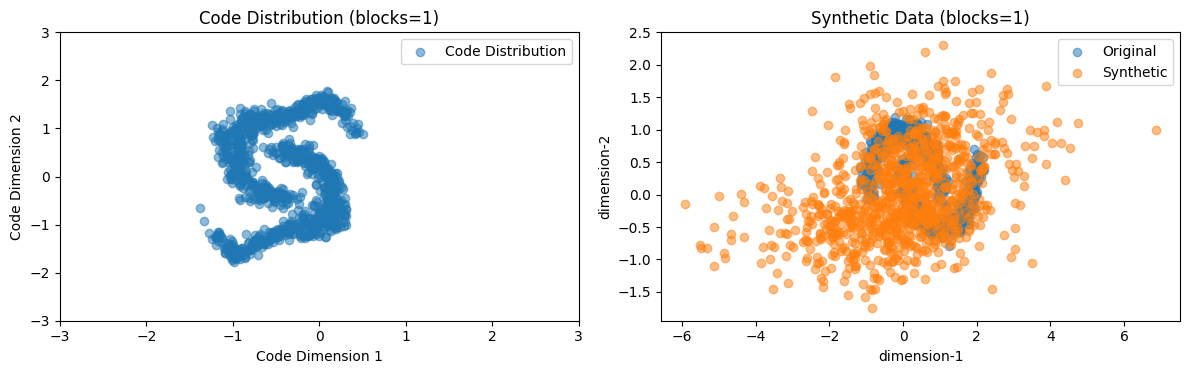

MMD Score (blocks=1): 0.0859

Training for blocks=2
Training complete


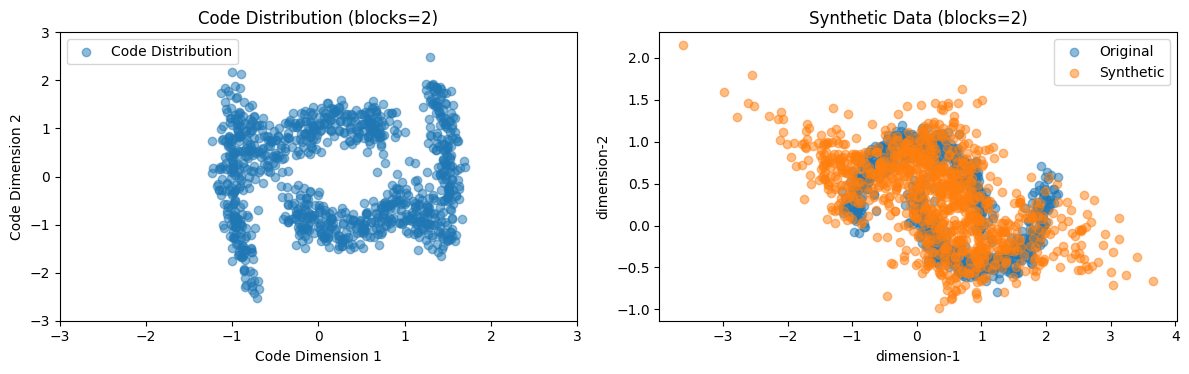

MMD Score (blocks=2): 0.0092

Training for blocks=10
Training complete


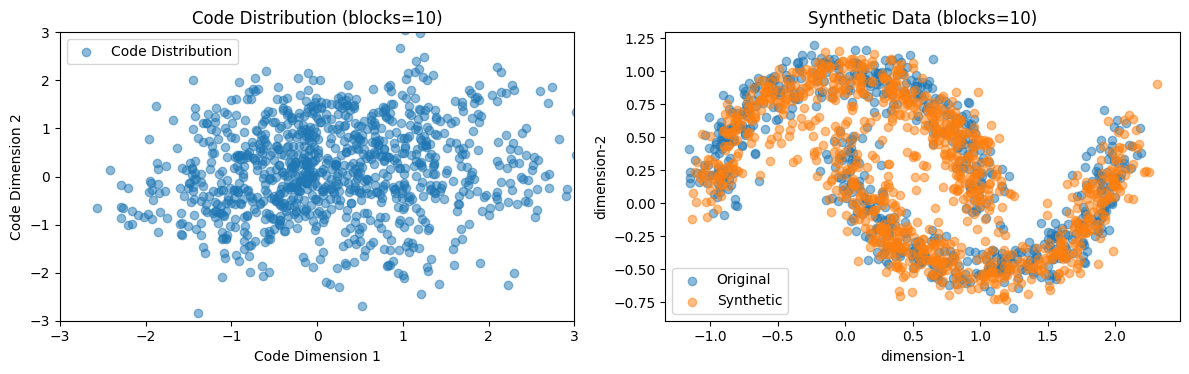

MMD Score (blocks=10): 0.0040

Training for blocks=15
Training complete


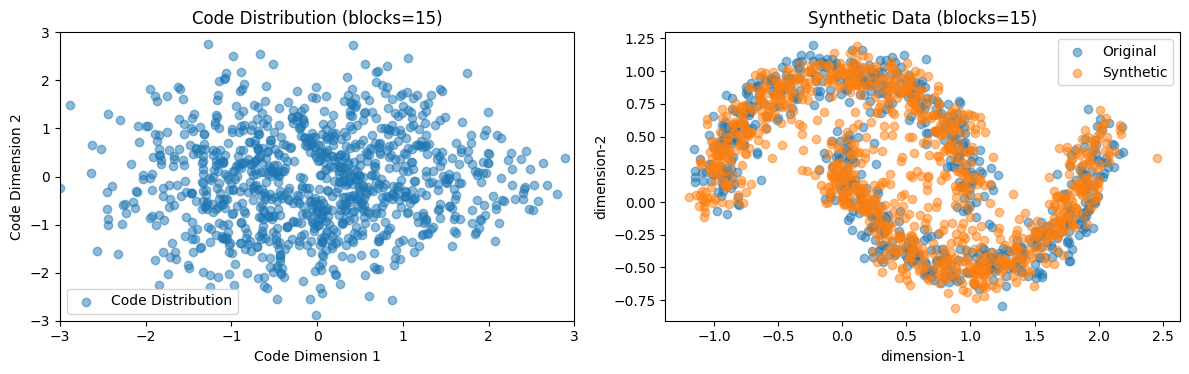

MMD Score (blocks=15): 0.0008


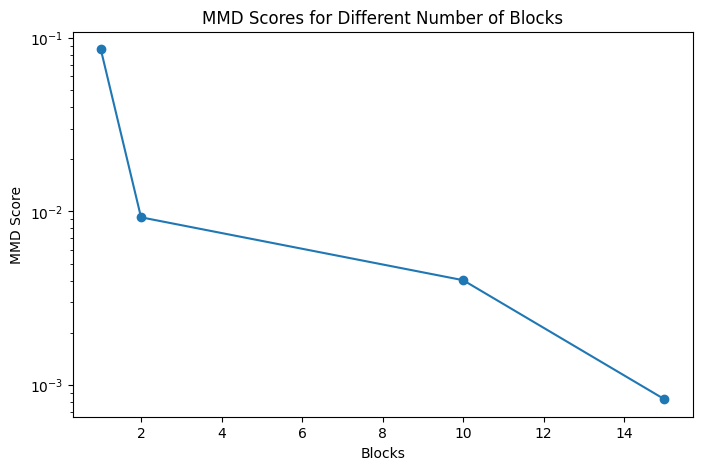

In [ ]:
### Input_size=2, hidden_size=200, lr=0.0001, num_epochs=10: Fixed
def train_and_plot_for_different_block_sizes(blocks_values, train_loader, val_loader):
    results = []

    for blocks in blocks_values:
        print(f"\nTraining for blocks={blocks}")
        # Instantiate the model
        model = RealNVP(input_size=2, hidden_size=200, blocks=blocks)

        # Train the model
        train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, num_epochs=10, lr=0.0001, print_after=100)

        # Plot code distribution
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plot_code_distribution(model=model, test_loader=val_loader, num_samples=1000)
        plt.title(f'Code Distribution (blocks={blocks})')

        # Plot synthetic data
        plt.subplot(1, 2, 2)
        synthetic_data = model.sample(num_samples=1000)
        visualize_synthetic_data(train_datasets[1000]['X'], synthetic_data)
        plt.title(f'Synthetic Data (blocks={blocks})')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        # # Calculate MMD score
        mmd_value = compute_mmd(val_loader.dataset, synthetic_data)
        print(f'MMD Score (blocks={blocks}): {mmd_value:.4f}')

        results.append((blocks, mmd_value))

    # # Plot MMD scores
    plt.figure(figsize=(8, 5))
    blocks, mmd_values = zip(*results)
    plt.plot(blocks, mmd_values, marker='o')
    plt.title('MMD Scores for Different Number of Blocks')
    plt.yscale('log')
    plt.xlabel('Blocks')
    plt.ylabel('MMD Score')
    plt.show()


######### for different coupling blocks


dataset_size=5000
print(f"For fixed dataset_size={dataset_size},  hidden_size=200, lr=0.0001, num_epochs=10")
batch_size=32
data_considered=train_datasets[dataset_size]['X']
print("shape of the data_considered"); print(data_considered.shape)
train_loader = torch.utils.data.DataLoader(data_considered, batch_size=batch_size, shuffle=True)
val_loader= torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)
####

blocks_values_to_try = [1,2,10,15]
train_and_plot_for_different_block_sizes(blocks_values_to_try, train_loader, val_loader)


### Observation:

1. Number of coupling blocks:

    1. We observed that the higher number of coupling blocks ensures that the code distribution is gaussian. We also observed improvement in the quality of synthetic data.

### 1.2 Effect of training set size

For fixed number of blocks=10,  hidden_size=200, lr=0.0001, num_epochs=10

Training for dataset_size=100
Training complete


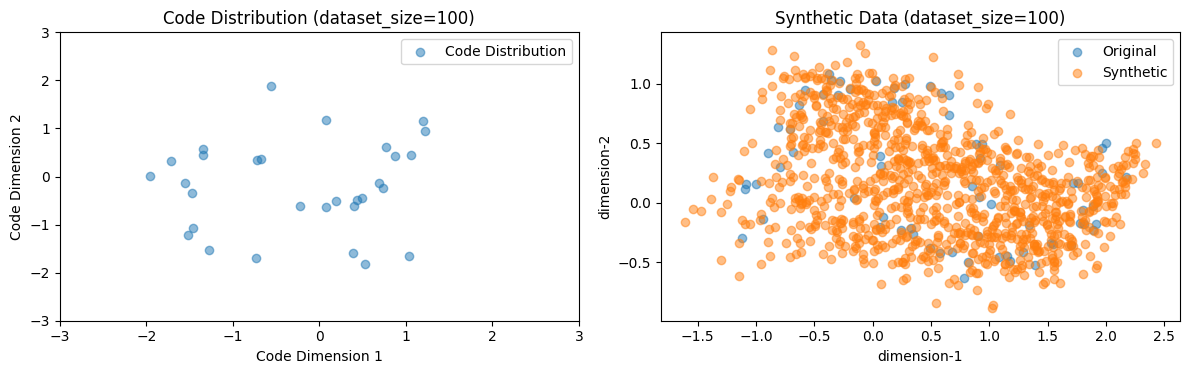

MMD Score (dataset_size=100): 0.0202

Training for dataset_size=200
Training complete


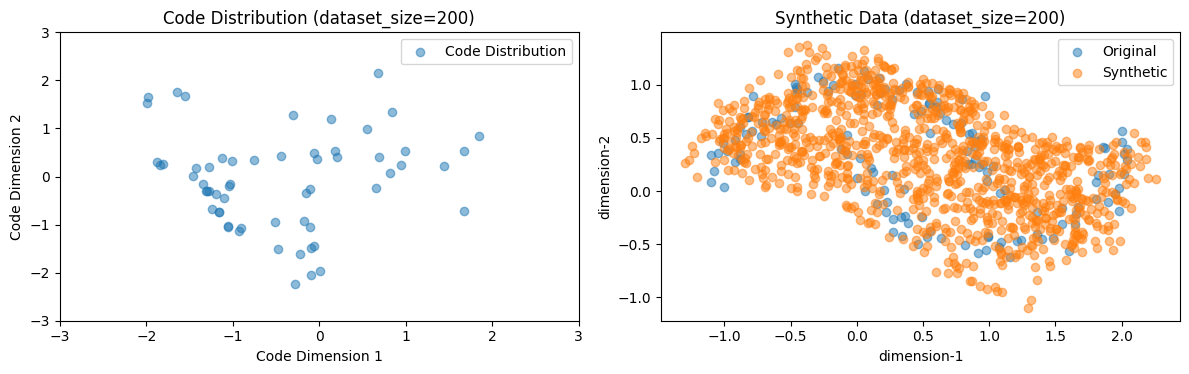

MMD Score (dataset_size=200): 0.0222

Training for dataset_size=300
Training complete


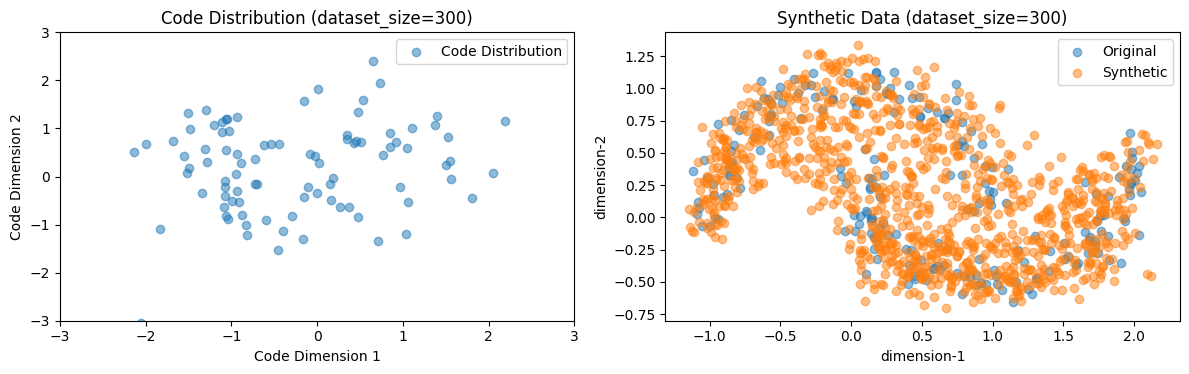

MMD Score (dataset_size=300): 0.0111

Training for dataset_size=400
Training complete


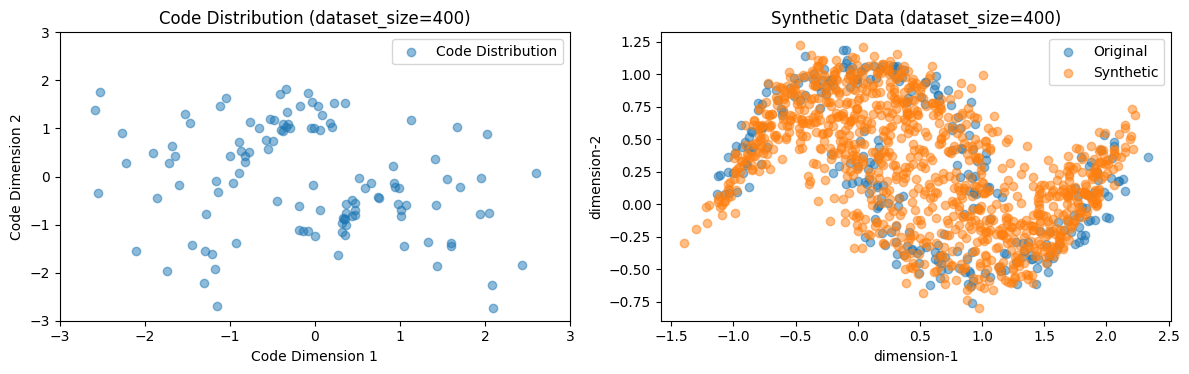

MMD Score (dataset_size=400): 0.0030

Training for dataset_size=500
Training complete


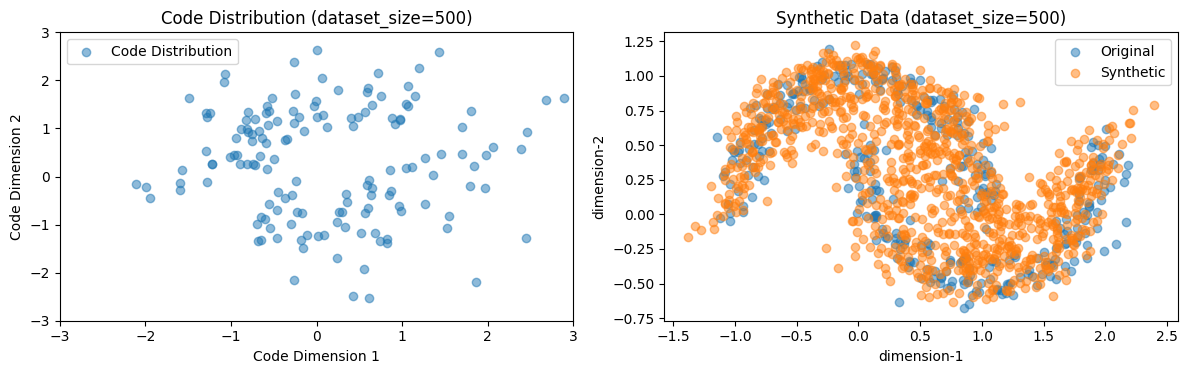

MMD Score (dataset_size=500): 0.0083

Training for dataset_size=600
Training complete


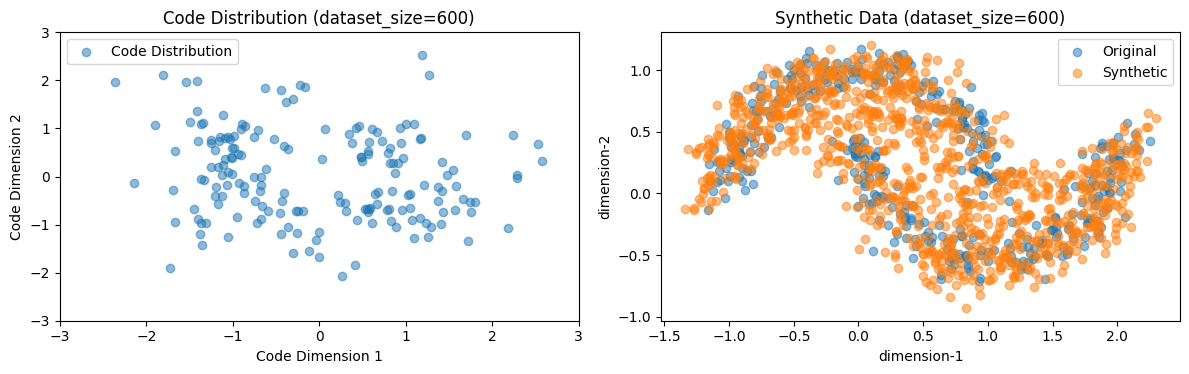

MMD Score (dataset_size=600): 0.0037

Training for dataset_size=700
Training complete


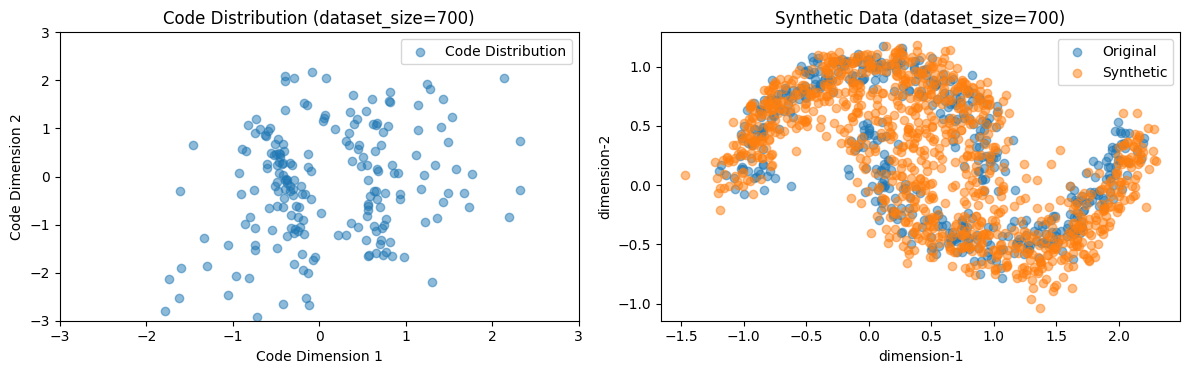

MMD Score (dataset_size=700): 0.0042

Training for dataset_size=800
Training complete


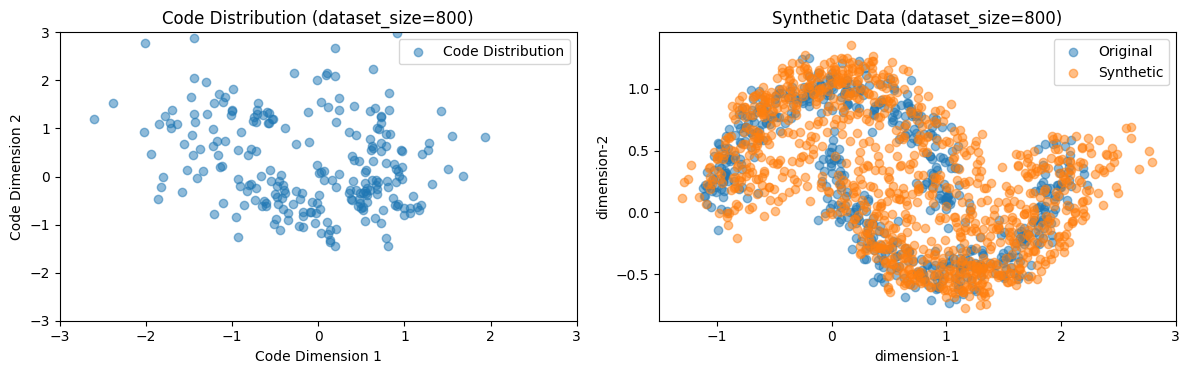

MMD Score (dataset_size=800): 0.0046

Training for dataset_size=900
Training complete


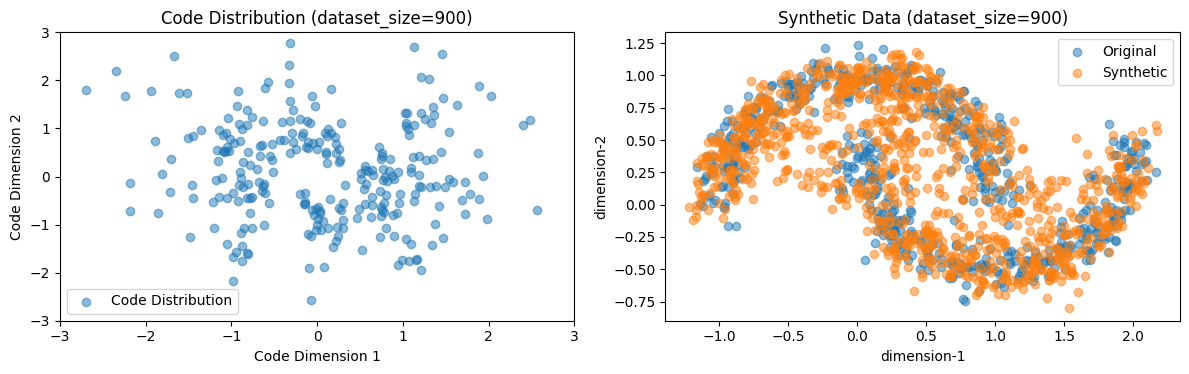

MMD Score (dataset_size=900): 0.0033

Training for dataset_size=1000
Training complete


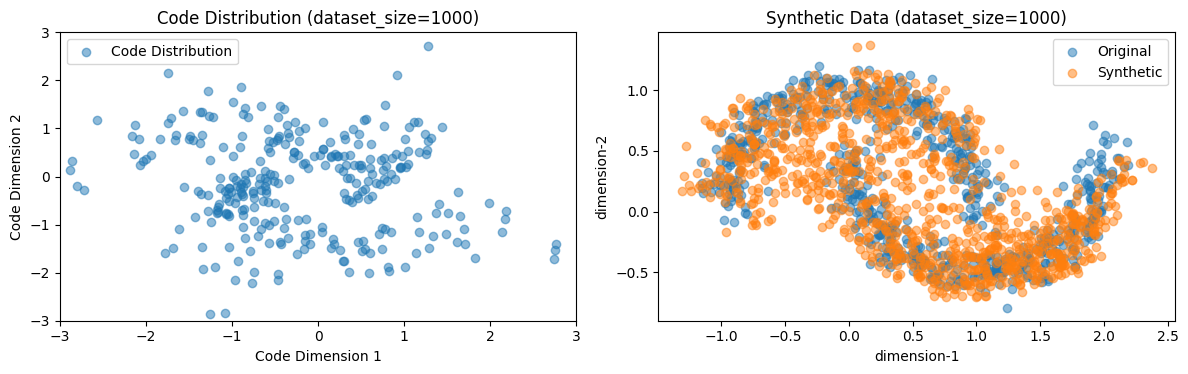

MMD Score (dataset_size=1000): 0.0052

Training for dataset_size=5000
Training complete


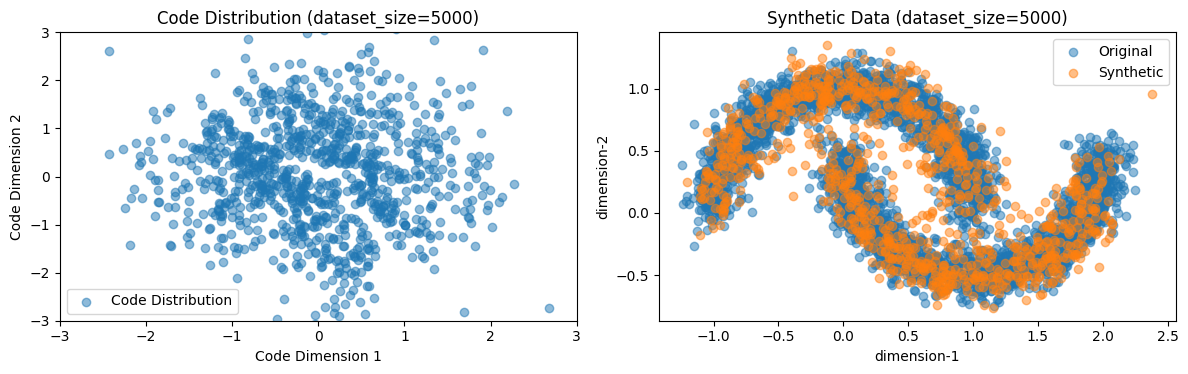

MMD Score (dataset_size=5000): 0.0015


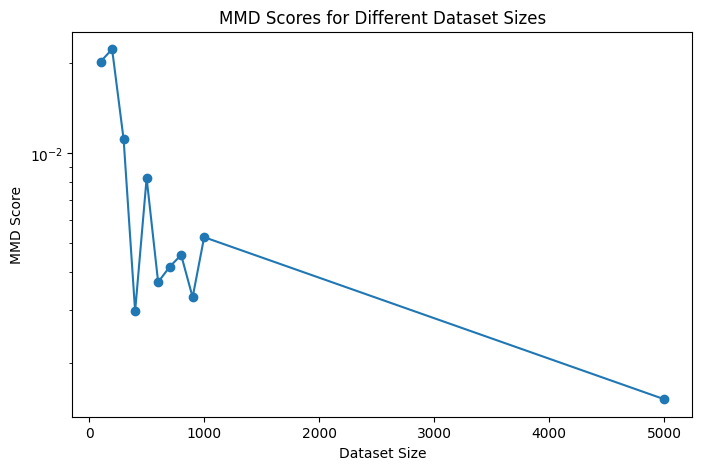

In [ ]:
def train_and_plot_for_different_dataset_sizes(dataset_sizes, train_loader, val_loader):
    results = []

    for dataset_size in dataset_sizes:
        print(f"\nTraining for dataset_size={dataset_size}")

        # Instantiate the model
        model = RealNVP(input_size=2, hidden_size=200, blocks=10)  # Fix other parameters

        # Create data loader for the current dataset size
        data_considered = train_datasets[dataset_size]['X']
        train_loader = torch.utils.data.DataLoader(data_considered, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=32, shuffle=True)

        # Train the model
        train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, num_epochs=10, lr=0.0001, print_after=100)

        # Plot code distribution
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plot_code_distribution(model=model, test_loader=val_loader, num_samples=1000)
        plt.title(f'Code Distribution (dataset_size={dataset_size})')

        # Plot synthetic data
        plt.subplot(1, 2, 2)
        synthetic_data = model.sample(num_samples=1000)
        visualize_synthetic_data(train_datasets[dataset_size]['X'], synthetic_data)
        plt.title(f'Synthetic Data (dataset_size={dataset_size})')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        # Calculate MMD score
        mmd_value = compute_mmd(val_loader.dataset, synthetic_data)
        print(f'MMD Score (dataset_size={dataset_size}): {mmd_value:.4f}')

        results.append((dataset_size, mmd_value))

    # Plot MMD scores
    plt.figure(figsize=(8, 5))
    dataset_sizes, mmd_values = zip(*results)
    plt.plot(dataset_sizes, mmd_values, marker='o')
    plt.title('MMD Scores for Different Dataset Sizes')
    plt.yscale('log')
    plt.xlabel('Dataset Size')
    plt.ylabel('MMD Score')
    plt.show()


# Different dataset sizes to try
print(f"For fixed number of blocks=10,  hidden_size=200, lr=0.0001, num_epochs=10")
dataset_sizes_to_try = [ 100, 200,300,400,500,600,700,800,900, 1000, 5000]
train_and_plot_for_different_dataset_sizes(dataset_sizes_to_try, train_loader, val_loader)


### Observation for different dataset sizes:

We did a few trial runs (of the cell above) for datasets of different sizes. We observed that in general, **The quality of synthetic dataset so generated increases with increase in the size of the dataset**.

### 1.3. Effect of Learning rate

For fixed number of blocks=10, hidden_size=200, dataset_size=1000, num_epochs=10

Training for learning rate=0.01
Epoch 1/10, Training Loss: 34249.63819585605, Validation Loss: 96.39350090026855
Epoch 2/10, Training Loss: 17.444855906746604, Validation Loss: 7.168351566791534
Epoch 3/10, Training Loss: 4.067275266755711, Validation Loss: 1.7464200377464294
Epoch 4/10, Training Loss: 2.238593506542119, Validation Loss: 1.4800371646881103
Epoch 5/10, Training Loss: 0.6588533046570691, Validation Loss: 1.2269035458564759
Epoch 6/10, Training Loss: 0.45849823634224857, Validation Loss: 0.467817023023963
Epoch 7/10, Training Loss: 0.2030923554716124, Validation Loss: -0.03832447938621044
Epoch 8/10, Training Loss: 0.16830856234512545, Validation Loss: 0.28604117035865784
Epoch 9/10, Training Loss: -0.005779499526728283, Validation Loss: 0.3927301362156868
Epoch 10/10, Training Loss: -0.03639907461845062, Validation Loss: -0.4005708858370781
Training complete


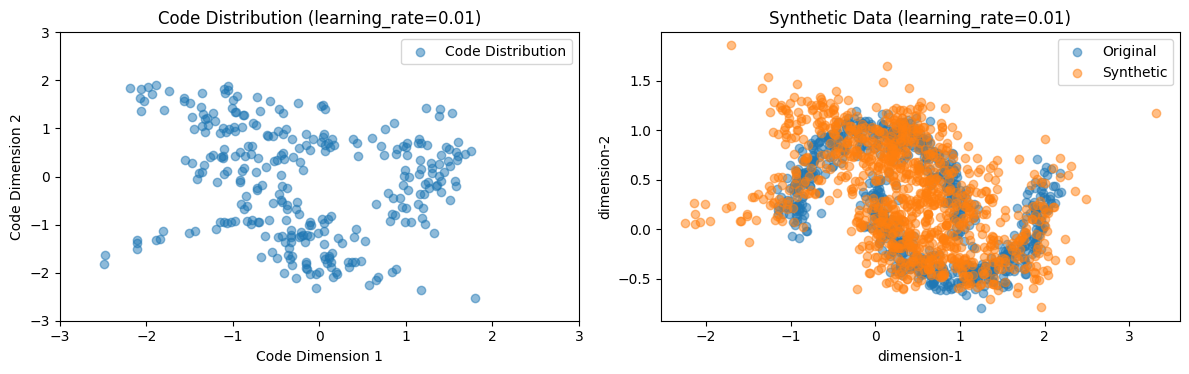

MMD Score (learning_rate=0.01): 0.0092

Training for learning rate=0.005
Epoch 1/10, Training Loss: 7124.812152223153, Validation Loss: 18.285866832733156
Epoch 2/10, Training Loss: 16.93183547258377, Validation Loss: 0.9407817333936691
Epoch 3/10, Training Loss: 0.8719681889369068, Validation Loss: 0.4983352357521653
Epoch 4/10, Training Loss: 0.5450281405144117, Validation Loss: 1.090432197600603
Epoch 5/10, Training Loss: 0.34591088664125313, Validation Loss: 0.26837621480226515
Epoch 6/10, Training Loss: 0.5659677324477922, Validation Loss: 2.179487055540085
Epoch 7/10, Training Loss: 0.23168667007121257, Validation Loss: 0.6240024253726005
Epoch 8/10, Training Loss: 0.14729561207985337, Validation Loss: -0.11129964124411344
Epoch 9/10, Training Loss: 0.047971172533421355, Validation Loss: 0.6229711942374706
Epoch 10/10, Training Loss: 0.030943154526705093, Validation Loss: 0.512635526061058
Training complete


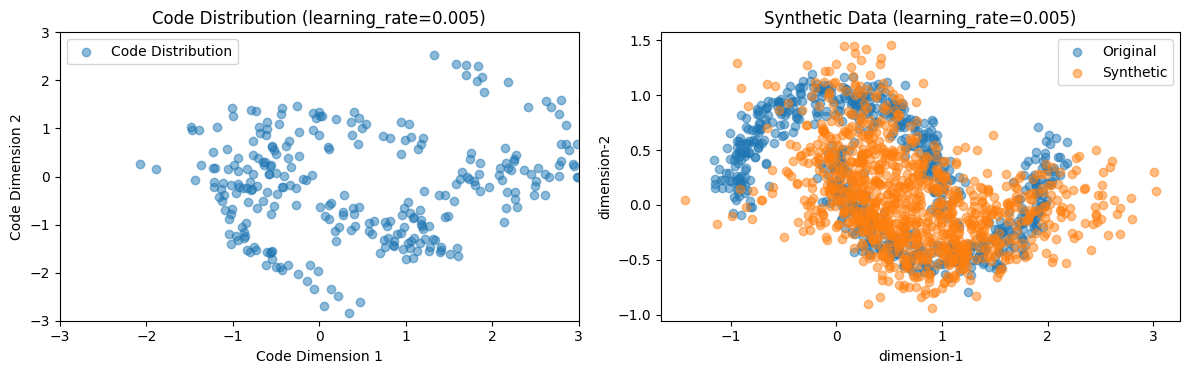

MMD Score (learning_rate=0.005): 0.0390

Training for learning rate=0.0005
Epoch 1/10, Training Loss: 0.27535917241634295, Validation Loss: 0.28086269050836565
Epoch 2/10, Training Loss: -0.12259117568927733, Validation Loss: -0.508315421640873
Epoch 3/10, Training Loss: -0.41551870124583895, Validation Loss: -1.2843954145908356
Epoch 4/10, Training Loss: -0.5599942166696895, Validation Loss: -1.3535277724266053
Epoch 5/10, Training Loss: -0.6964739473028616, Validation Loss: -1.5749985337257386
Epoch 6/10, Training Loss: -0.6182747063311663, Validation Loss: -1.220973151922226
Epoch 7/10, Training Loss: -0.774790192192251, Validation Loss: -1.6232745498418808
Epoch 8/10, Training Loss: -0.7209373617714102, Validation Loss: -1.8560085892677307
Epoch 9/10, Training Loss: -0.7334688204255971, Validation Loss: -1.8728285908699036
Epoch 10/10, Training Loss: -0.8474934588779103, Validation Loss: -1.9058189570903779
Training complete


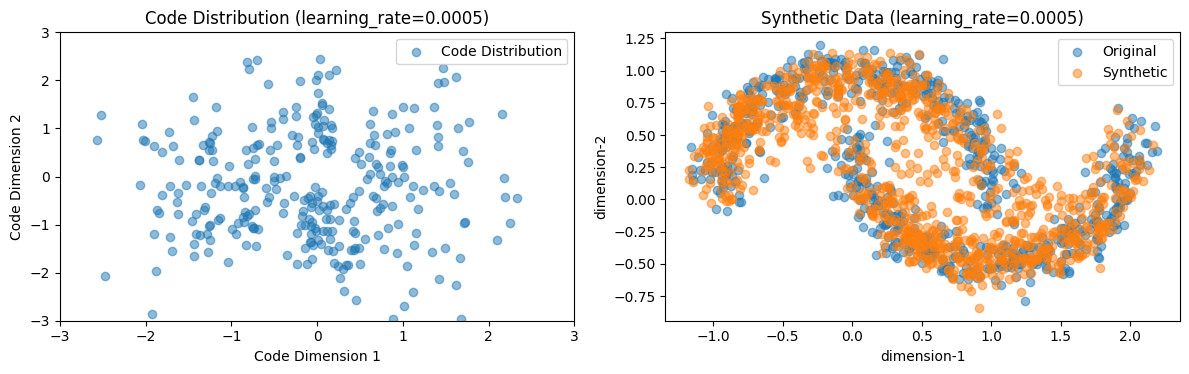

MMD Score (learning_rate=0.0005): 0.0040

Training for learning rate=0.0001
Epoch 1/10, Training Loss: -0.039960643615234985, Validation Loss: -0.6333849906921387
Epoch 2/10, Training Loss: -0.4425783130255612, Validation Loss: -1.1143998503684998
Epoch 3/10, Training Loss: -0.5625381903214888, Validation Loss: -1.2678691446781158
Epoch 4/10, Training Loss: -0.6130500249564648, Validation Loss: -1.2670856088399887
Epoch 5/10, Training Loss: -0.6736022778363391, Validation Loss: -1.41335671544075
Epoch 6/10, Training Loss: -0.748089115050706, Validation Loss: -1.533460158109665
Epoch 7/10, Training Loss: -0.7076883912086487, Validation Loss: -1.5807082772254943
Epoch 8/10, Training Loss: -0.7326247963038358, Validation Loss: -1.6012744575738906
Epoch 9/10, Training Loss: -0.7824559110132131, Validation Loss: -1.4656340681016444
Epoch 10/10, Training Loss: -0.7503130446103486, Validation Loss: -1.7036002993583679
Training complete


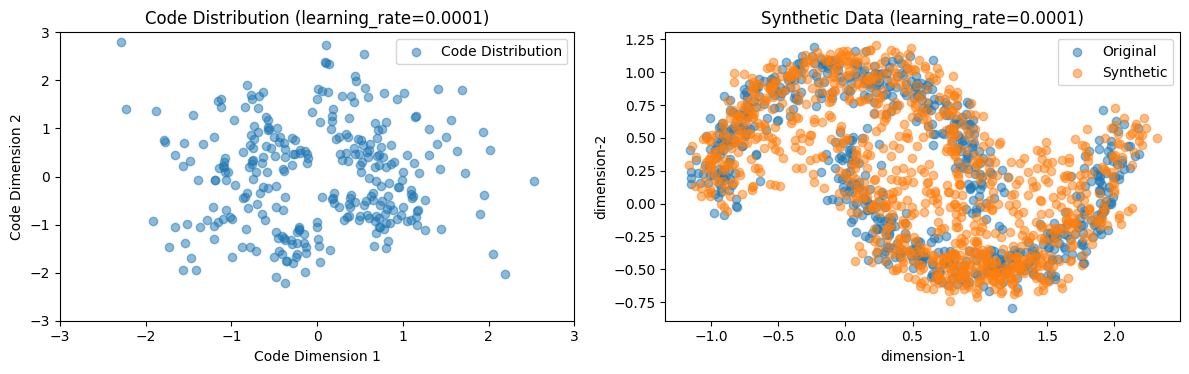

MMD Score (learning_rate=0.0001): 0.0026

Training for learning rate=5e-06
Epoch 1/10, Training Loss: 1.2291955731131814, Validation Loss: 2.1337529182434083
Epoch 2/10, Training Loss: 0.9065462134101174, Validation Loss: 1.5555740356445313
Epoch 3/10, Training Loss: 0.6489063094962727, Validation Loss: 1.0809697687625885
Epoch 4/10, Training Loss: 0.4313817877661098, Validation Loss: 0.6914171934127807
Epoch 5/10, Training Loss: 0.26260134429586207, Validation Loss: 0.39127640016376974
Epoch 6/10, Training Loss: 0.13626123484837907, Validation Loss: 0.18431425811722874
Epoch 7/10, Training Loss: 0.05357656776190693, Validation Loss: 0.04856752827763557
Epoch 8/10, Training Loss: -0.0024029213765805416, Validation Loss: -0.03913313699886203
Epoch 9/10, Training Loss: -0.0413973746207458, Validation Loss: -0.10918909907341004
Epoch 10/10, Training Loss: -0.07296358068097933, Validation Loss: -0.16762189529836177
Training complete


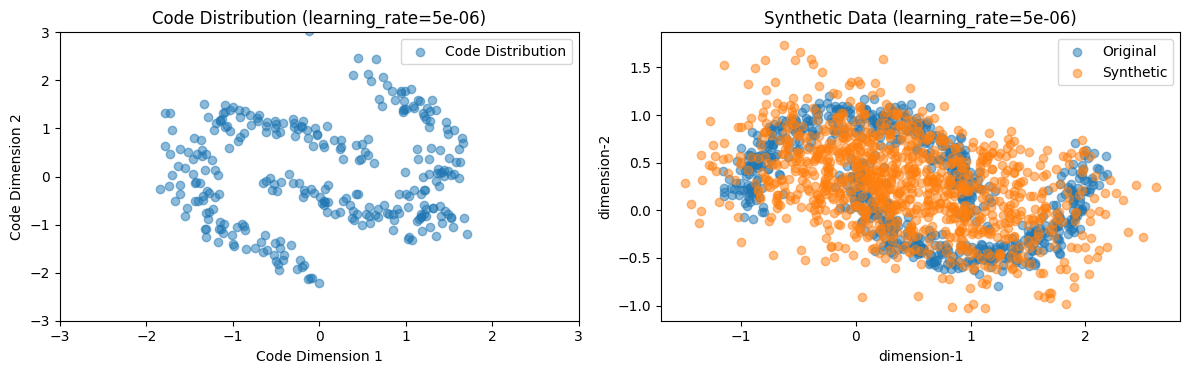

MMD Score (learning_rate=5e-06): 0.0101


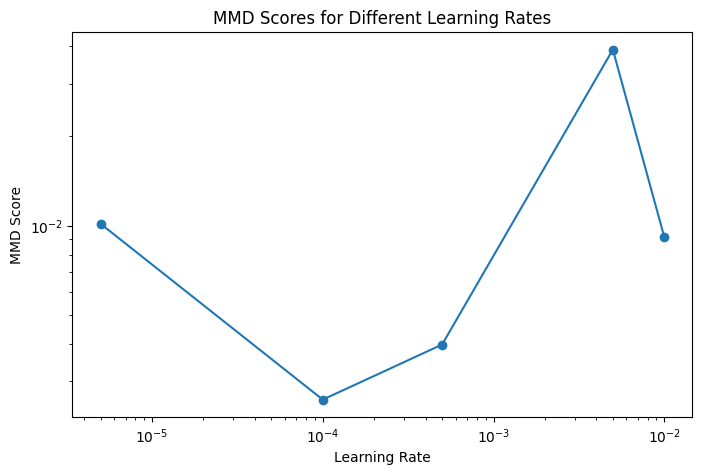

In [ ]:
def train_and_plot_for_different_learning_rates(learning_rates, dataset_size=1000, block_size=10):
    results = []

    for lr in learning_rates:
        print(f"\nTraining for learning rate={lr}")

        # Instantiate the model
        model = RealNVP(input_size=2, hidden_size=200, blocks=block_size)  # Fix other parameters

        # Create data loader for the fixed dataset size
        data_considered = train_datasets[dataset_size]['X']
        train_loader = torch.utils.data.DataLoader(data_considered, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=32, shuffle=True)

        # Train the model
        train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, num_epochs=10, lr=lr, print_after=1)

        # Plot code distribution
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plot_code_distribution(model=model, test_loader=val_loader, num_samples=1000)
        plt.title(f'Code Distribution (learning_rate={lr})')

        # Plot synthetic data
        plt.subplot(1, 2, 2)
        synthetic_data = model.sample(num_samples=1000)
        visualize_synthetic_data(train_datasets[dataset_size]['X'], synthetic_data)
        plt.title(f'Synthetic Data (learning_rate={lr})')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        # Calculate MMD score
        mmd_value = compute_mmd(val_loader.dataset, synthetic_data)
        print(f'MMD Score (learning_rate={lr}): {mmd_value:.4f}')

        results.append((lr, mmd_value))

    # Plot MMD scores
    plt.figure(figsize=(8, 5))
    learning_rates, mmd_values = zip(*results)
    plt.plot(learning_rates, mmd_values, marker='o')
    plt.title('MMD Scores for Different Learning Rates')
    plt.xlabel('Learning Rate')
    plt.ylabel('MMD Score')
    plt.xscale('log')  # Use a logarithmic scale for better visualization of different orders of magnitude
    plt.yscale('log')
    plt.show()


# Different learning rates to try
print("For fixed number of blocks=10, hidden_size=200, dataset_size=1000, num_epochs=10")
learning_rates_to_try = [0.01,0.005,0.0005,0.0001,0.000005]
train_and_plot_for_different_learning_rates(learning_rates_to_try, dataset_size=1000, block_size=10)


### Observation:

We observed that the lower learning rates were suited best for the real NVP (INN) model. We found the learning rate of `1e-4` the most suitable for this case.

### 1.4. Effect of number of epochs

For fixed number of blocks=10, hidden_size=200, dataset_size=5000, lr=0.0001

Training for num_epochs=10
Epoch 2/10, Training Loss: -0.14358886231414297, Validation Loss: -0.2803282976742497
Epoch 4/10, Training Loss: -0.17533571784469215, Validation Loss: -0.4116998964801748
Epoch 6/10, Training Loss: -0.18580710415474394, Validation Loss: -0.4493791166138142
Epoch 8/10, Training Loss: -0.1960323669609021, Validation Loss: -0.4617179879482756
Epoch 10/10, Training Loss: -0.20351748117669063, Validation Loss: -0.48170990528578456
Training complete


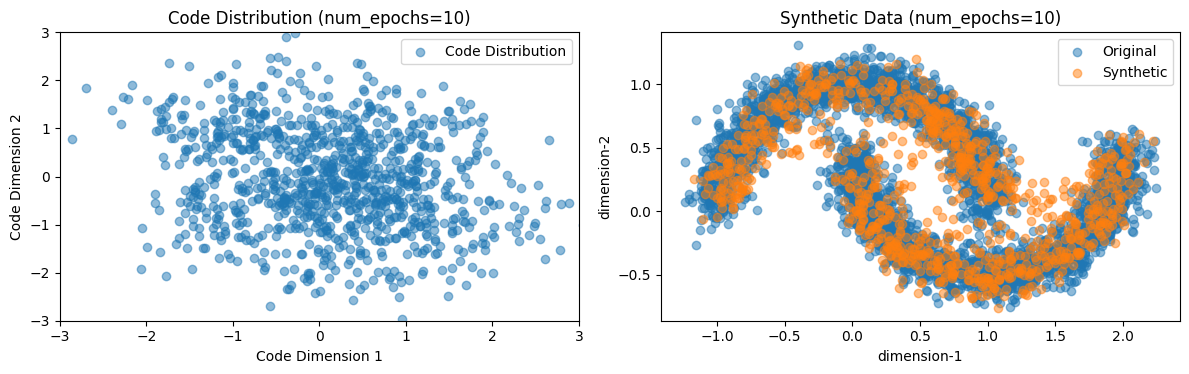

MMD Score (num_epochs=10): 0.0073

Training for num_epochs=40
Epoch 2/40, Training Loss: -0.1378864387388934, Validation Loss: -0.3690203459973031
Epoch 4/40, Training Loss: -0.1580163512632928, Validation Loss: -0.38746916185668173
Epoch 6/40, Training Loss: -0.17779654987495053, Validation Loss: -0.43654367295985524
Epoch 8/40, Training Loss: -0.1889630897986618, Validation Loss: -0.4552901840590416
Epoch 10/40, Training Loss: -0.19047909550030123, Validation Loss: -0.42791273777789257
Epoch 12/40, Training Loss: -0.19354358423839915, Validation Loss: -0.4706975151883795
Epoch 14/40, Training Loss: -0.2010810967704112, Validation Loss: -0.46784974095669196
Epoch 16/40, Training Loss: -0.2049939930523661, Validation Loss: -0.44716153975496903
Epoch 18/40, Training Loss: -0.20869793099435893, Validation Loss: -0.49485309897585117
Epoch 20/40, Training Loss: -0.20657219410958616, Validation Loss: -0.4554901722263783
Epoch 22/40, Training Loss: -0.20321482946588235, Validation Loss: -0.4

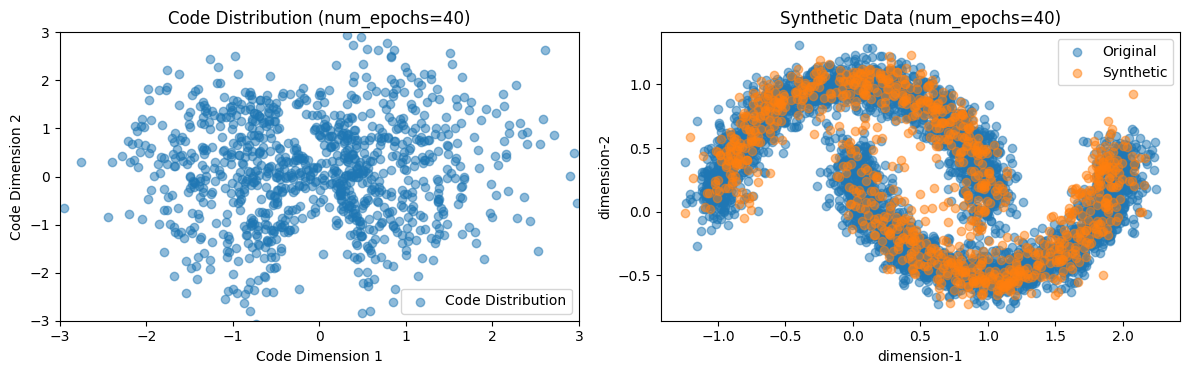

MMD Score (num_epochs=40): 0.0046

Training for num_epochs=70
Epoch 2/70, Training Loss: -0.13076824862668715, Validation Loss: -0.37503495146619514
Epoch 4/70, Training Loss: -0.1627920740707354, Validation Loss: -0.40823768808486616
Epoch 6/70, Training Loss: -0.1742848001081835, Validation Loss: -0.4192498841501297
Epoch 8/70, Training Loss: -0.19004247720268638, Validation Loss: -0.4279984803275859
Epoch 10/70, Training Loss: -0.19786307911642573, Validation Loss: -0.46302134083940627
Epoch 12/70, Training Loss: -0.20096099491823805, Validation Loss: -0.42286763165859464
Epoch 14/70, Training Loss: -0.20947395664724436, Validation Loss: -0.3848408782418738
Epoch 16/70, Training Loss: -0.21476675871420992, Validation Loss: -0.47927849850756055
Epoch 18/70, Training Loss: -0.21008852278305726, Validation Loss: -0.5150847650588827
Epoch 20/70, Training Loss: -0.21329289078712463, Validation Loss: -0.5035497875923806
Epoch 22/70, Training Loss: -0.21433152136477557, Validation Loss: -0

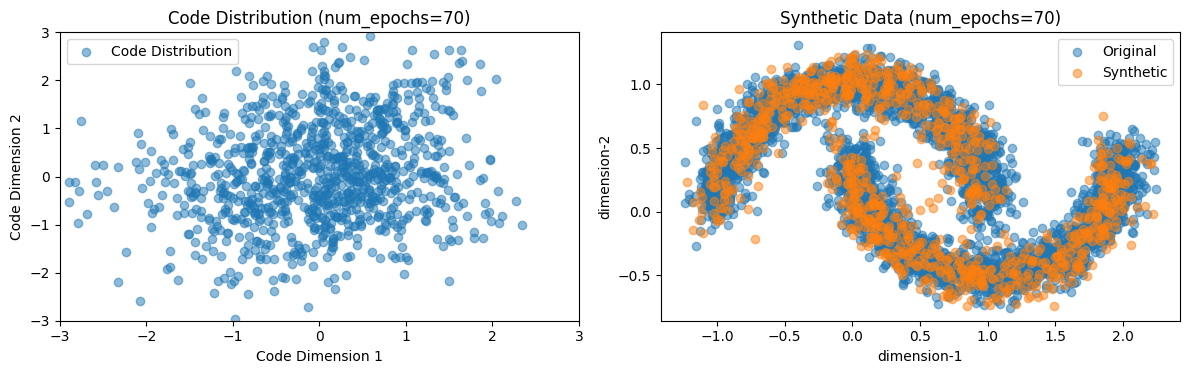

MMD Score (num_epochs=70): 0.0015

Training for num_epochs=100
Epoch 2/100, Training Loss: -0.13594088523902675, Validation Loss: -0.3640339044814414
Epoch 4/100, Training Loss: -0.1487430640072985, Validation Loss: -0.39018139021193726
Epoch 6/100, Training Loss: -0.1542976822873408, Validation Loss: -0.42238458230140363
Epoch 8/100, Training Loss: -0.16581505732187493, Validation Loss: -0.38754124382629673
Epoch 10/100, Training Loss: -0.17620162418831817, Validation Loss: -0.41299855043279365
Epoch 12/100, Training Loss: -0.1797038776524873, Validation Loss: -0.46067460800739046
Epoch 14/100, Training Loss: -0.1875358109193092, Validation Loss: -0.4512183618672351
Epoch 16/100, Training Loss: -0.19431041539223357, Validation Loss: -0.46909774491127504
Epoch 18/100, Training Loss: -0.19388091472739524, Validation Loss: -0.47596237412158476
Epoch 20/100, Training Loss: -0.19564713624475355, Validation Loss: -0.4955769181251526
Epoch 22/100, Training Loss: -0.19411445575004274, Validat

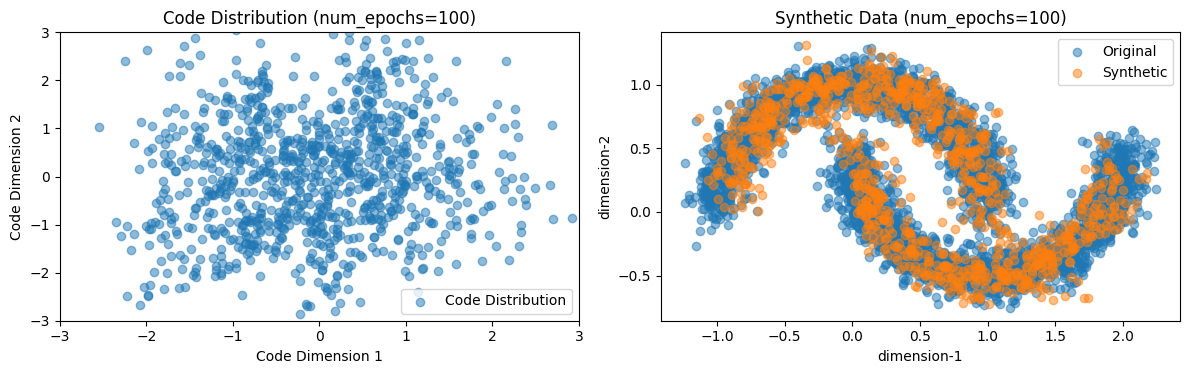

MMD Score (num_epochs=100): 0.0038


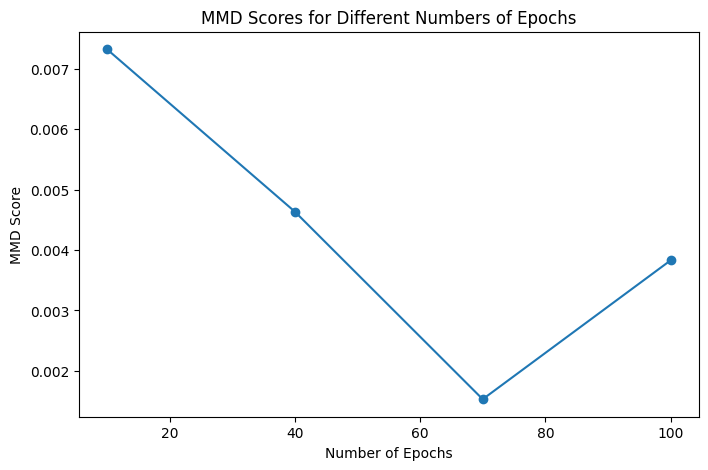

In [ ]:
def train_and_plot_for_different_epochs(epochs_list, dataset_size=1000, block_size=10, lr=0.0001):
    results = []

    for num_epochs in epochs_list:
        print(f"\nTraining for num_epochs={num_epochs}")

        # Instantiate the model
        model = RealNVP(input_size=2, hidden_size=200, blocks=block_size)  # Fix other parameters

        # Create data loader for the fixed dataset size
        data_considered = train_datasets[dataset_size]['X']
        train_loader = torch.utils.data.DataLoader(data_considered, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=32, shuffle=True)

        # Train the model
        train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, num_epochs=num_epochs, lr=lr, print_after=2)

        # Plot code distribution
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plot_code_distribution(model=model, test_loader=val_loader, num_samples=1000)
        plt.title(f'Code Distribution (num_epochs={num_epochs})')

        # Plot synthetic data
        plt.subplot(1, 2, 2)
        synthetic_data = model.sample(num_samples=1000)
        visualize_synthetic_data(train_datasets[dataset_size]['X'], synthetic_data)
        plt.title(f'Synthetic Data (num_epochs={num_epochs})')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        # Calculate MMD score
        mmd_value = compute_mmd(val_loader.dataset, synthetic_data)
        print(f'MMD Score (num_epochs={num_epochs}): {mmd_value:.4f}')

        results.append((num_epochs, mmd_value))

    # Plot MMD scores
    plt.figure(figsize=(8, 5))
    num_epochs_values, mmd_values = zip(*results)
    plt.plot(num_epochs_values, mmd_values, marker='o')
    plt.title('MMD Scores for Different Numbers of Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('MMD Score')
    plt.show()


# Different numbers of epochs to try
print("For fixed number of blocks=10, hidden_size=200, dataset_size=5000, lr=0.0001")
epochs_to_try = [10,40,70,100]
train_and_plot_for_different_epochs(epochs_to_try, dataset_size=5000, block_size=10, lr=0.0001)


# DONE (for 2 moons dataset atleast):~Tasks for the prob 1 of exercise 2 we need to do:~

Hyperparameters involved:

1. Size of the training set
2. Number of epochs
3. Learning rate


*  Check the effect of these 3 hyperparameters on the model quality.
      1. Check for the quality of the code distribution (it should be indeed standard normal)
      2. Check the quality of the generated data: RealNVP should have a function `RealNVP.sample(self,num_samples)` that generates the requested number of synthetic points. REPORT the MMD between a testset and generated datapoints: to be mre specific show that visually better results correspond to the smaller MMD.

### ~~Tasks to do atm~~:

1. ~~check if the model is implemented correctly.~~
2. MOST IMPORTANTLY: is the loss function implemented correctly? when I return the abs(loss) in the `calculate_loss` function, I see some training and improvement. IDK whether the loss function I have implemented is correct or not!

# Question 2. Conditional INN

In [43]:
### conditional coupling layer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot

class ConditionalCouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        """
        Initialize a ConditionalCouplingLayer.

        Args:
        - input_size (int): Total size of the input data.
        - hidden_size (int): Size of the hidden layers in the neural networks.
        - condition_size (int): Size of the condition vector (e.g., one-hot encoded label size).
        """
        super(ConditionalCouplingLayer, self).__init__()
        # Neural networks for the first half of the dimensions
        self.fc1 = nn.Linear(input_size // 2 + condition_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Translation coefficient
        self.fc3 = nn.Linear(hidden_size, input_size // 2)
        # Scaling coefficient
        self.fc4 = nn.Linear(hidden_size, input_size // 2)

    def forward(self, x, condition):
        """
        Forward pass through the ConditionalCouplingLayer.

        Args:
        - x (torch.Tensor): Input data.
        - condition (torch.Tensor): Condition vector.

        Returns:
        - y (torch.Tensor): Transformed data.
        - scaling_before_exp (torch.Tensor): Scaling coefficients before the exponential operation.
        """
        # Split the input into two halves
        x_a, x_b = x.chunk(2, dim=1)

        # Concatenate conditions to the first half
        x_a_concat = torch.cat([x_a, condition], dim=1)

        # Apply neural network to calculate coefficients
        h = F.relu(self.fc1(x_a_concat))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling_before_exp = torch.tanh(self.fc4(h))
        scaling = torch.exp(scaling_before_exp)

        # Apply the affine transformation
        y_b = x_b * scaling + translation

        # Concatenate the transformed halves
        y = torch.cat([x_a, y_b], dim=1)
        return y, scaling_before_exp

    def backward(self, y, condition):
        """
        Backward pass through the ConditionalCouplingLayer.

        Args:
        - y (torch.Tensor): Transformed data.
        - condition (torch.Tensor): Condition vector.

        Returns:
        - x (torch.Tensor): Reconstructed original input.
        """
        # Split the input into two halves
        y_a, y_b = y.chunk(2, dim=1)

        # Concatenate conditions to the first half
        y_a_concat = torch.cat([y_a, condition], dim=1)

        # Apply neural network to calculate coefficients (reverse)
        h = F.relu(self.fc1(y_a_concat))
        h = F.relu(self.fc2(h))
        translation = self.fc3(h)
        scaling_before_exp = self.fc4(h)
        scaling = torch.exp(torch.tanh(scaling_before_exp))

        # Reverse the operations to reconstruct the original input
        x_a = y_a
        x_b = (y_b - translation) / scaling

        # Concatenate the reconstructed halves
        x = torch.cat([x_a, x_b], dim=1)
        return x

In [44]:
### conditional real NVP class
class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size, blocks):
        """
        Initialize a ConditionalRealNVP model.

        Args:
        - input_size (int): Total size of the input data.
        - hidden_size (int): Size of the hidden layers in the neural networks.
        - condition_size (int): Size of the condition vector (e.g., one-hot encoded label size).
        - blocks (int): Number of coupling layers in the model.
        """
        super(ConditionalRealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.blocks = blocks

        # List of coupling layers
        self.coupling_layers = nn.ModuleList([
            ConditionalCouplingLayer(input_size, hidden_size, condition_size) for _ in range(blocks)
        ])

        # List to store orthonormal matrices
        self.orthonormal_matrices = [self._get_orthonormal_matrix(input_size) for _ in range(blocks)]

        # List to store scaling_before_exp for each block
        self.scaling_before_exp_list = []

    def _get_orthonormal_matrix(self, size):
        """
        Generate a random orthonormal matrix.

        Args:
        - size (int): Size of the matrix.

        Returns:
        - q (torch.Tensor): Orthonormal matrix.
        """
        w = torch.randn(size, size)
        q, _ = torch.linalg.qr(w, 'reduced')
        return q

    def forward_realnvp(self, x, condition):
        """
        Forward pass through the ConditionalRealNVP model.

        Args:
        - x (torch.Tensor): Input data.
        - condition (torch.Tensor): Condition vector.

        Returns:
        - x (torch.Tensor): Transformed data.
        """
        scaling_before_exp_list = []
        for i in range(self.blocks):
            #print("x is:"); print(x)
            #print("shape of x is:"); print(x.shape)
            x = torch.matmul(x, self.orthonormal_matrices[i])
            x, scaling_before_exp = self.coupling_layers[i].forward(x, condition)
            scaling_before_exp_list.append(scaling_before_exp)

        self.scaling_before_exp_list = scaling_before_exp_list
        return x

    def decode(self, z, condition):
        """
        Reverse transformations to decode data.

        Args:
        - z (torch.Tensor): Transformed data.
        - condition (torch.Tensor): Condition vector.

        Returns:
        - z (torch.Tensor): Reconstructed original data.
        """
        for i in reversed(range(self.blocks)):
            z = self.coupling_layers[i].backward(z, condition)
            z = torch.matmul(z, self.orthonormal_matrices[i].t())
        return z

    def sample(self, num_samples=1000, conditions=None):
        """
        Generate synthetic samples.

        Args:
        - num_samples (int): Number of synthetic samples to generate.
        - conditions (torch.Tensor): Conditions for generating synthetic samples.

        Returns:
        - synthetic_samples (torch.Tensor): Synthetic samples.
        """
        with torch.no_grad():
            z = torch.randn(num_samples, self.input_size)
            synthetic_samples = self.decode(z, conditions)
        return synthetic_samples


In [45]:
### training_the_conditional_nvp model

import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

def train_and_validate_conditional_nvp(model, train_loader, val_loader, num_epochs=10, lr=0.001, print_after=1):
    """
    Train the ConditionalRealNVP model and evaluate on a validation dataset.

    Args:
    - model (ConditionalRealNVP): The ConditionalRealNVP model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses

    for epoch in range(num_epochs):
        total_train_loss = 0.0

        # Training phase
        model.train()  # Set the model to training mode
        for data, labels in train_loader:
            inputs = data
            conditions = one_hot(labels, num_classes=model.condition_size).float()

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model.forward_realnvp(inputs, conditions)

            # Loss calculation
            train_loss = calculate_loss(encoded, model.scaling_before_exp_list, len(train_loader))

            # Backward pass (gradient computation)
            train_loss.backward()

            # Clip gradients to prevent exploding gradients
            clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            optimizer.step()

            total_train_loss += train_loss.item()

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data, val_labels in val_loader:
                    val_inputs = val_data
                    val_conditions = one_hot(val_labels, num_classes=model.condition_size).float()

                    # Forward pass (encoding) for validation
                    val_encoded = model.forward_realnvp(val_inputs, val_conditions)

                    # Loss calculation for validation
                    val_loss = calculate_loss(val_encoded, model.scaling_before_exp_list, len(val_loader))

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}")

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    return train_losses, val_losses

In [46]:
### Create the dataset and dataloaders for the conditional NVP model
dataset_sizes = [ 100, 200,300,400,500,600,700,800,900, 1000, 5000]

# Generate datasets of varying sizes
train_datasets = {}
val_datasets = {}
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'data': X, 'labels': y}### label imply to which moon does it belong to
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_datasets[size] = {'data': torch.FloatTensor(X_train), 'label': y_train}
    val_datasets[size] = {'data': torch.FloatTensor(X_test), 'label': y_test}


In [47]:
#### data for the two-moons model
from torch.utils.data import TensorDataset, DataLoader

# Define a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y


### task 1. train the conditional INN

In [74]:
# Define model parameters
input_size = 2
hidden_size = 200
condition_size = 2
blocks = 10

# Initialize the model
conditional_inn_model = ConditionalRealNVP(input_size, hidden_size, condition_size, blocks)

# Define hyperparameters
num_epochs = 10
lr = 0.0001

# Create datasets
dataset_size=1000
train_dataset = CustomDataset(train_datasets[dataset_size]['data'], train_datasets[dataset_size]['label'])
val_dataset = CustomDataset(val_datasets[dataset_size]['data'], val_datasets[dataset_size]['label'])

# Define batch size
batch_size = 32

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Task 1: Train the Conditional INN
train_loss, val_loss= train_and_validate_conditional_nvp(conditional_inn_model, train_loader, val_loader,
                                                         num_epochs=num_epochs, lr=lr, print_after=1)

# # plotting the loss
# plot_losses(train_losses[3:], val_losses[3:], want_log_scale=0)
# plt.show()

Epoch 1/10, Training Loss: -0.006406580351970412, Validation Loss: -1.6474494695663453
Epoch 2/10, Training Loss: -1.0011240054260602, Validation Loss: -2.5908217787742616
Epoch 3/10, Training Loss: -1.3734492984685032, Validation Loss: -3.228589582443237
Epoch 4/10, Training Loss: -1.6193950718099421, Validation Loss: -3.613426983356476
Epoch 5/10, Training Loss: -1.8065144311298023, Validation Loss: -3.933247423171997
Epoch 6/10, Training Loss: -1.9050252112475308, Validation Loss: -4.168292987346649
Epoch 7/10, Training Loss: -1.997774985703555, Validation Loss: -4.331017470359802
Epoch 8/10, Training Loss: -2.017071404240348, Validation Loss: -4.2837486743927
Epoch 9/10, Training Loss: -2.0419710007580845, Validation Loss: -4.320469224452973
Epoch 10/10, Training Loss: -1.9935572797601873, Validation Loss: -4.370506072044373
Training complete


### task 2. generate the "conditonal data".

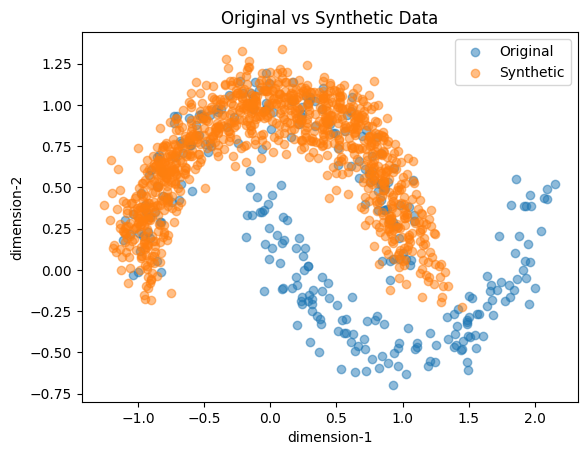

In [75]:
# Choose a label for evaluation (e.g., label 0)
eval_condition = torch.tensor([[1, 0]])  # One-hot encoding for label 0

# Repeat the condition vector for each sample
eval_condition = eval_condition.repeat(1000, 1)

with torch.no_grad():
    # Generate synthetic samples for the chosen label
    synthetic_samples_label_0 = conditional_inn_model.sample(num_samples=1000, conditions=eval_condition)

# # Example usage:
# plot_code_distribution(model=conditional_inn_model, test_loader=val_loader, num_samples=1000)
# plt.show()

### plot the synthetic data and the original data
visualize_synthetic_data(val_datasets[1000]['data'], synthetic_samples_label_0)
plt.show()

### task 3. Merge synthetic data from all labels and compare the marginal distributions.

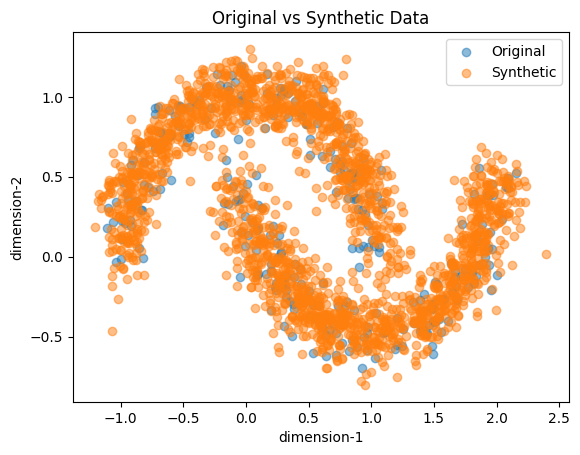

MMD Score (dataset_size=1000): 0.0015


In [76]:
# Generate synthetic samples for all labels
conditions_all_labels = torch.eye(condition_size)  # Assuming one-hot encoding

# Repeat the condition vector for each sample
conditions_all_labels = conditions_all_labels.repeat(1000, 1)

with torch.no_grad():
    synthetic_samples_all_labels = conditional_inn_model.sample(num_samples=2000, conditions=conditions_all_labels)

visualize_synthetic_data(val_datasets[1000]['data'], synthetic_samples_all_labels)
plt.show()

### calculate the MMD score:
mmd_value = compute_mmd(val_datasets[1000]['data'], synthetic_samples_all_labels)
print(f'MMD Score (dataset_size={dataset_size}): {mmd_value:.4f}')

### Observation:

We found that the quai when we trained our networks (a) simple RealNVP model and (b) conditional real NVP model with same set of parameters/hyperparameters (dataset_size=1000, num_epochs=10, blocks=10 and lr=0.00001), the quality of the synthetic data generated in the latter was better than the former!

### Question 1: with gaussian mixture dataset

### Generating the gaussian mixture dataset with centers at the corners of a regular hexagon.

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def generate_hexagon_centers(radius):
    """Generate the coordinates of the corners of a regular hexagon."""
    centers = []
    for i in range(6):
        angle = i * (2 * np.pi) / 6
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        centers.append((x, y))
    return np.array(centers)

def generate_gaussian_mixture(num_samples, radius, std_factor=0.1):
    """Generate a Gaussian mixture dataset with centers at the corners of a regular hexagon."""
    centers = generate_hexagon_centers(radius)
    dataset = []

    for center in centers:
        # Generate samples for each center
        samples = center + np.random.normal(scale=radius * std_factor, size=(num_samples // 6, 2))
        dataset.extend(samples)

    return np.array(dataset)


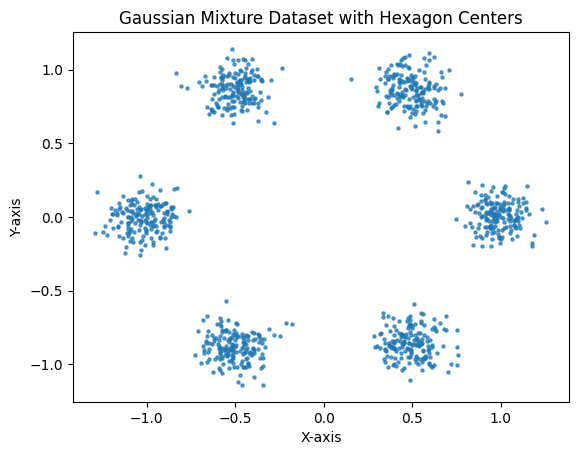

In [81]:
# Parameters
num_samples = 1000  # Total number of samples
radius = 1.0       # Radius of the hexagon

# Generate Gaussian mixture dataset
data = generate_gaussian_mixture(num_samples, radius)

# Plot the dataset
plt.scatter(data[:, 0], data[:, 1], s=5, alpha=0.7)
plt.title("Gaussian Mixture Dataset with Hexagon Centers")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [99]:
### creating dataloader for the GMM data for the task 1
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split



train_data.shape: torch.Size([6997, 2])


train_data.shape: torch.Size([3498, 2])
Epoch 1/10, Training Loss: -0.09264865262349221, Validation Loss: -0.4578422463320671
Epoch 2/10, Training Loss: -0.22378539214418694, Validation Loss: -0.5686360806860822
Epoch 3/10, Training Loss: -0.26564742543480613, Validation Loss: -0.6057762481430744
Epoch 4/10, Training Loss: -0.3008011854507706, Validation Loss: -0.7171168531826202
Epoch 5/10, Training Loss: -0.3147314602678472, Validation Loss: -0.770908589058734
Epoch 6/10, Training Loss: -0.3358232593671842, Validation Loss: -0.7703726751422708
Epoch 7/10, Training Loss: -0.32794816206124694, Validation Loss: -0.7865931096863239
Epoch 8/10, Training Loss: -0.34763822876424955, Validation Loss: -0.80317840487399
Epoch 9/10, Training Loss: -0.35555108917707745, Validation Loss: -0.8539800466375148
Epoch 10/10, Training Loss: -0.37260157574306835, Validation Loss: -0.802230251913375
Training complete


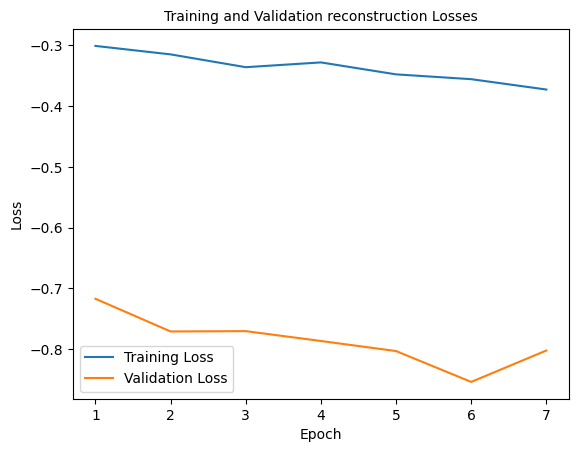

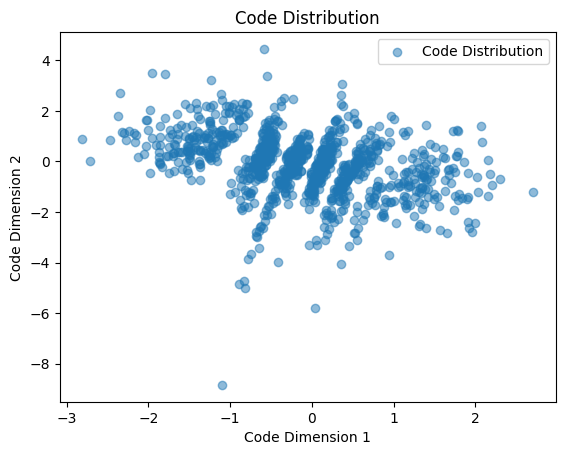

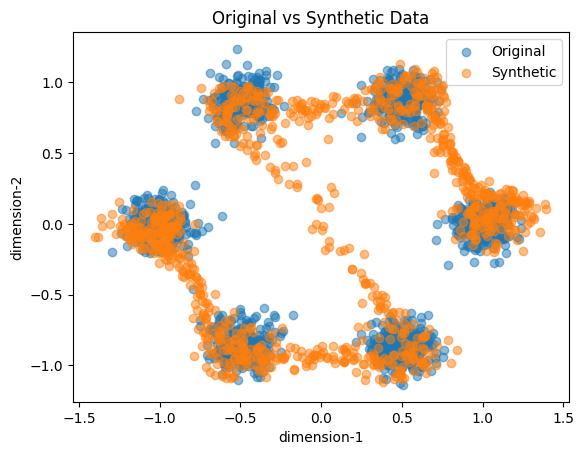

In [102]:
# Parameters
num_samples = 5000 # Total number of samples
radius = 1.0       # Radius of the hexagon

# Generate Gaussian mixture dataset
data = generate_gaussian_mixture(num_samples, radius)

# Convert NumPy array to PyTorch tensor
tensor_data = torch.FloatTensor(data)

# Split the data into training, validation, and test sets
train_data, val_data = train_test_split(tensor_data, test_size=0.3, random_state=42,)
# val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)
print("train_data.shape:",train_data.shape)

# Create DataLoaders for training, validation, and test sets
batch_size = 32
train_loader_gmm = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader_gmm = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader_gmm = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

### train the real NVP on this gaussian mixture dataset using the good hyperparameters and parameter setting

### instantiate the model
model= RealNVP(input_size=2, hidden_size= hidden_size, blocks=blocks)

## train the model
train_losses, val_losses= train_and_evaluate(model, train_loader_gmm, val_loader_gmm, num_epochs=10, lr=0.0001, print_after=1)

# plotting the loss
plot_losses(train_losses[3:], val_losses[3:], want_log_scale=0)
plt.show()

# Example usage:
plot_code_distribution(model=model, test_loader=val_loader_gmm, num_samples=1000)
plt.show()

### plot the synthetic data and the original data
synthetic_data=model.sample(num_samples=1000)
visualize_synthetic_data(val_data, synthetic_data)
plt.show()

for number of blocks (of coupling layers) = 10
Epoch 1/10, Training Loss: -0.1711568475065922, Validation Loss: -0.4166206436905455
Epoch 2/10, Training Loss: -0.2179773619864136, Validation Loss: -0.6880392254667079
Epoch 3/10, Training Loss: -0.2668281264603138, Validation Loss: -0.689277319515005
Epoch 4/10, Training Loss: -0.2784070844497447, Validation Loss: -0.7866703741093899
Epoch 5/10, Training Loss: -0.30405897423624995, Validation Loss: -0.778896229064211
Epoch 6/10, Training Loss: -0.3153127140672454, Validation Loss: -0.8288024359561027
Epoch 7/10, Training Loss: -0.32933646491305396, Validation Loss: -0.8716362587949062
Epoch 8/10, Training Loss: -0.33827141137708994, Validation Loss: -0.7992005241995163
Epoch 9/10, Training Loss: -0.35097551332278687, Validation Loss: -0.9301682013146421
Epoch 10/10, Training Loss: -0.3742963306605816, Validation Loss: -0.9089916665503319
Training complete


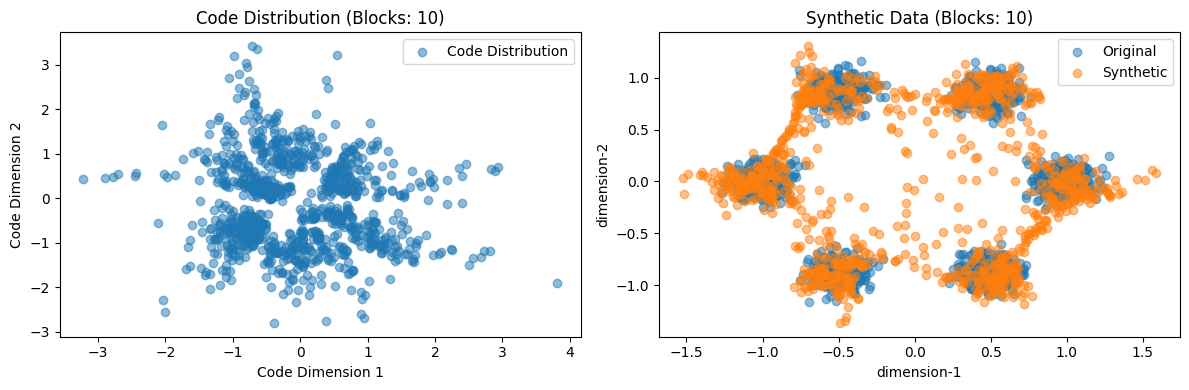

for number of blocks (of coupling layers) = 15
Epoch 1/10, Training Loss: -0.18399374967186966, Validation Loss: -0.5483809021559167
Epoch 2/10, Training Loss: -0.261074180460789, Validation Loss: -0.7353821178858585
Epoch 3/10, Training Loss: -0.29642295600338414, Validation Loss: -0.6786448701899103
Epoch 4/10, Training Loss: -0.3193064758046107, Validation Loss: -0.6730123887512278
Epoch 5/10, Training Loss: -0.3120895107234405, Validation Loss: -0.6880445689597028
Epoch 6/10, Training Loss: -0.35195273391225124, Validation Loss: -0.7357196268883157
Epoch 7/10, Training Loss: -0.34705201255326923, Validation Loss: -0.8573546206697504
Epoch 8/10, Training Loss: -0.365441263534806, Validation Loss: -0.799792338558968
Epoch 9/10, Training Loss: -0.3740568820048462, Validation Loss: -0.890588160524977
Epoch 10/10, Training Loss: -0.38332980458032, Validation Loss: -0.8855564321609254
Training complete


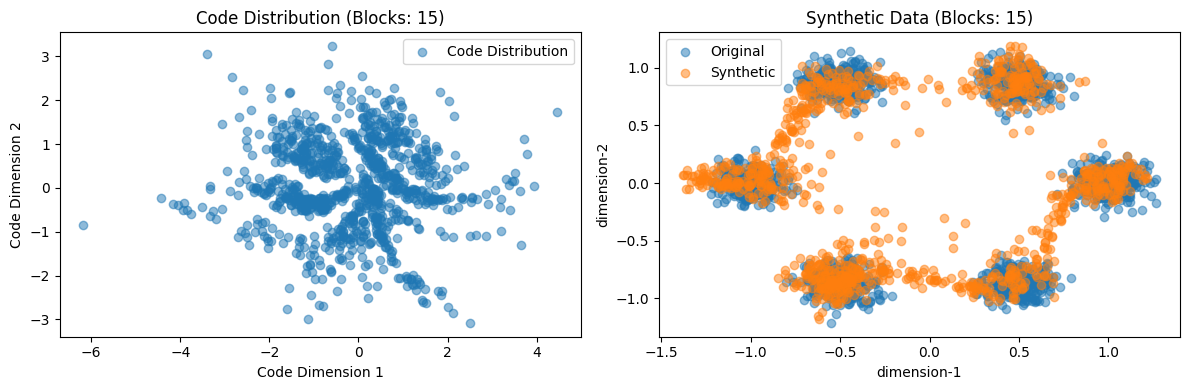

for number of blocks (of coupling layers) = 20
Epoch 1/10, Training Loss: -0.15773297304033557, Validation Loss: 0.0816506451748787
Epoch 2/10, Training Loss: -0.28194965305314823, Validation Loss: -0.6531605783929216
Epoch 3/10, Training Loss: -0.3283293927257711, Validation Loss: -0.5806136478451972
Epoch 4/10, Training Loss: -0.3638733426278288, Validation Loss: -0.9073914619202309
Epoch 5/10, Training Loss: -0.38593369979750025, Validation Loss: -0.9376398109375162
Epoch 6/10, Training Loss: -0.39313019812107086, Validation Loss: -0.6554167257978561
Epoch 7/10, Training Loss: -0.377121215923266, Validation Loss: -0.8188236932805244
Epoch 8/10, Training Loss: -0.3975151603872126, Validation Loss: -0.894000733152349
Epoch 9/10, Training Loss: -0.410280722447417, Validation Loss: -1.0394295872525965
Epoch 10/10, Training Loss: -0.4077042386613109, Validation Loss: -0.862802190983549
Training complete


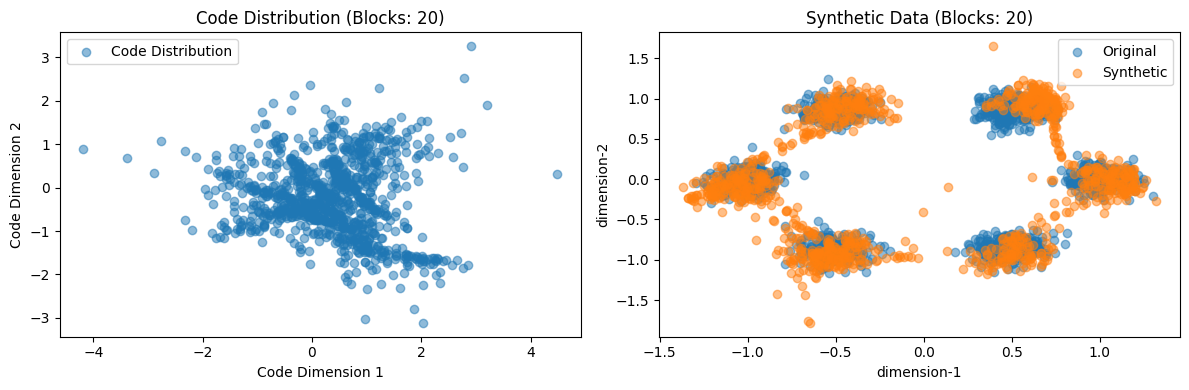

In [109]:
# for different number of blocks
# hyperparameter setting: (dataset_size=5000, lr=0.0001, num_epochs=10). We will consider different number of blocks
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

def train_evaluate_plot(blocks):
    # Parameters
    num_samples = 5000  # Total number of samples
    radius = 1.0        # Radius of the hexagon
    hidden_size = 256    # Hidden size in the neural networks

    # Generate Gaussian mixture dataset
    data = generate_gaussian_mixture(num_samples, radius)

    # Convert NumPy array to PyTorch tensor
    tensor_data = torch.FloatTensor(data)

    # Split the data into training and validation sets
    train_data, val_data = train_test_split(tensor_data, test_size=0.3, random_state=42)

    # Create DataLoaders for training and validation sets
    batch_size = 32
    train_loader_gmm = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader_gmm = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    model = RealNVP(input_size=2, hidden_size=hidden_size, blocks=blocks)

    # Train the model
    train_and_evaluate(model, train_loader_gmm, val_loader_gmm, num_epochs=10, lr=0.0001, print_after=1)

    # Plot the code distribution and synthetic data as a 2x1 subplot
    plt.figure(figsize=(12, 4))

    # Plot Code Distribution
    plt.subplot(1, 2, 1)
    plot_code_distribution(model=model, test_loader=val_loader_gmm, num_samples=1000)
    plt.title(f'Code Distribution (Blocks: {blocks})')

    # Plot Synthetic Data
    plt.subplot(1, 2, 2)
    synthetic_data = model.sample(num_samples=1000)
    visualize_synthetic_data(val_data, synthetic_data)
    plt.title(f'Synthetic Data (Blocks: {blocks})')

    plt.tight_layout()
    plt.show()

# Train and evaluate the model for different numbers of blocks
blocks_list = [10, 15, 20]

for blocks in blocks_list:
    print(f"for number of blocks (of coupling layers) = {blocks}")
    train_evaluate_plot(blocks)


### Observation (training the `RealNVP` model on the gaussian mixture dataset):

We noticed that in general, it is more difficult to train model on GMM dataset than on the two-moons dataset. We had to consider more no. of coupling layer blocks for som e improvement

### Question: 2 with Gaussian mixture

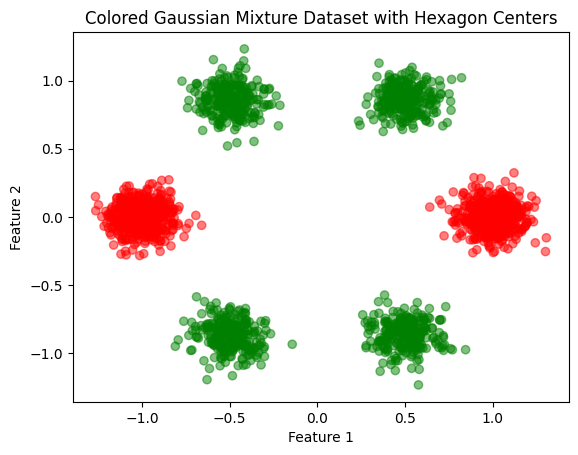

In [115]:
import numpy as np
import torch
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

def generate_colored_gaussian_mixture(num_samples, red_centers, green_centers, red_std=0.1, green_std=0.1):
    # Generate data for red peaks (label 0)
    red_samples = np.concatenate([np.random.normal(center, red_std, size=(num_samples // len(red_centers), 2)) for center in red_centers])

    # Generate data for green peaks (label 1)
    green_samples = np.concatenate([np.random.normal(center, green_std, size=(num_samples // len(green_centers), 2)) for center in green_centers])

    # Concatenate data and labels
    data = np.concatenate([red_samples, green_samples])
    labels = np.concatenate([np.zeros(len(red_samples)), np.ones(len(green_samples))])

    # Shuffle the data
    shuffle_idx = np.arange(len(data))
    np.random.shuffle(shuffle_idx)
    data = data[shuffle_idx]
    labels = labels[shuffle_idx]

    return torch.FloatTensor(data), torch.LongTensor(labels)

# Set the parameters for the hexagon
radius = 1.0
theta = np.linspace(0, 2*np.pi, 6, endpoint=False)
hexagon_centers = radius * np.column_stack([np.cos(theta), np.sin(theta)])

# Red centers are two opposite corners of the hexagon
red_centers = hexagon_centers[[0, 3]]

# Green centers are the remaining corners of the hexagon
green_centers = np.delete(hexagon_centers, [0, 3], axis=0)

# Generate the colored Gaussian mixture dataset
num_samples = 1000
gmm_data, gmm_labels = generate_colored_gaussian_mixture(num_samples, red_centers, green_centers)

# Visualize the generated data with red and green colors
colors = ['red' if label == 0 else 'green' for label in gmm_labels.numpy()]
plt.scatter(gmm_data[:, 0], gmm_data[:, 1], c=colors, alpha=0.5)
plt.title("Colored Gaussian Mixture Dataset with Hexagon Centers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [142]:
### creating the dataloaders

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Generate the colored Gaussian mixture dataset
num_samples = 1000
gmm_data, gmm_labels = generate_colored_gaussian_mixture(num_samples, red_centers, green_centers)

# Split the data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(gmm_data, gmm_labels, test_size=0.3, random_state=42)

# Create custom dataset class
class CustomGaussianDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

# Create datasets and dataloaders
batch_size = 32

# Training dataset and dataloader
train_dataset_gmm = CustomGaussianDataset(train_data, train_labels)
train_loader_gmm = torch.utils.data.DataLoader(train_dataset_gmm, batch_size=batch_size, shuffle=True)

# Validation dataset and dataloader
val_dataset_gmm = CustomGaussianDataset(val_data, val_labels)
val_loader_gmm = torch.utils.data.DataLoader(val_dataset_gmm, batch_size=batch_size, shuffle=False)

In [146]:
print(train_data); print(train_labels)

tensor([[ 0.8894, -0.1983],
        [ 1.1001,  0.0337],
        [-0.5155, -0.8477],
        ...,
        [-0.6511,  0.7452],
        [-0.6721,  0.7671],
        [-0.9938, -0.0904]])
tensor([0, 0, 1,  ..., 1, 1, 0])


In [151]:
### training the conditional real nvp model on this labelled gaussian mixture model
input_size = 2
hidden_size = 200
condition_size = 2
blocks = 10

# Initialize the model
conditional_inn_model_gmm = ConditionalRealNVP(input_size, hidden_size, condition_size, blocks)

# Task 1: Train the Conditional INN
train_loss, val_loss= train_and_validate_conditional_nvp(conditional_inn_model_gmm, train_loader_gmm, val_loader_gmm,
                                                         num_epochs=10, lr=0.0001, print_after=1)

Epoch 1/10, Training Loss: -0.3862612232915126, Validation Loss: -2.1432569654364335
Epoch 2/10, Training Loss: -1.064291232011535, Validation Loss: -2.50752087643272
Epoch 3/10, Training Loss: -1.1634336225688457, Validation Loss: -2.6443190511904264
Epoch 4/10, Training Loss: -1.2350565262816169, Validation Loss: -3.0219727189917314
Epoch 5/10, Training Loss: -1.3032633133909919, Validation Loss: -2.9245845330388924
Epoch 6/10, Training Loss: -1.310829065062783, Validation Loss: -2.843032397721943
Epoch 7/10, Training Loss: -1.354095148769292, Validation Loss: -3.1350309597818473
Epoch 8/10, Training Loss: -1.4046222811395472, Validation Loss: -3.3079374463934648
Epoch 9/10, Training Loss: -1.4157851297747006, Validation Loss: -3.2862295351530375
Epoch 10/10, Training Loss: -1.441434383392334, Validation Loss: -3.4128858415704024
Training complete


### task 2: generate the "conditonal data".

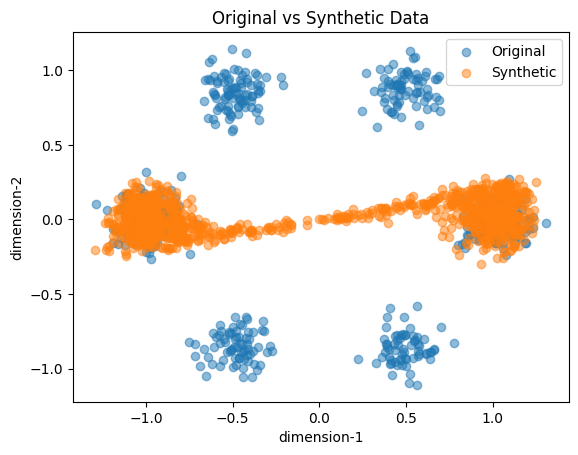

In [152]:
# Choose a label for evaluation (e.g., label 0)
eval_condition = torch.tensor([[1, 0]])  # One-hot encoding for label 0

# Repeat the condition vector for each sample
eval_condition = eval_condition.repeat(1000, 1)

with torch.no_grad():
    # Generate synthetic samples for the chosen label
    synthetic_samples_label_0 = conditional_inn_model_gmm.sample(num_samples=1000, conditions=eval_condition)

# # Example usage:
# plot_code_distribution(model=conditional_inn_model, test_loader=val_loader, num_samples=1000)
# plt.show()

### plot the synthetic data and the original data
visualize_synthetic_data(val_data, synthetic_samples_label_0)
plt.show()

### task 3: Merge synthetic data from all labels and compare the marginal distributions.

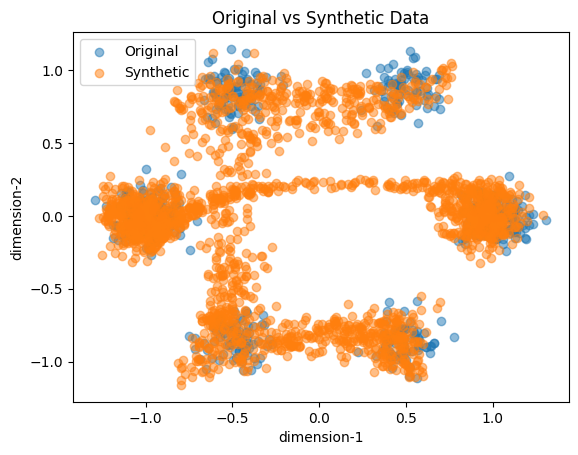

MMD Score (dataset_size=1000): 0.0168


In [153]:
# Generate synthetic samples for all labels
conditions_all_labels = torch.eye(condition_size)  # Assuming one-hot encoding

# Repeat the condition vector for each sample
conditions_all_labels = conditions_all_labels.repeat(1000, 1)

with torch.no_grad():
    synthetic_samples_all_labels = conditional_inn_model.sample(num_samples=2000, conditions=conditions_all_labels)

visualize_synthetic_data(val_data, synthetic_samples_all_labels)
plt.show()

### calculate the MMD score:
mmd_value = compute_mmd(val_data, synthetic_samples_all_labels)
print(f'MMD Score (dataset_size={dataset_size}): {mmd_value:.4f}')

### add some comments for this!